# SETUP

## Check environment

In [1]:
USE_GPU = True

In [2]:
try:
    import google.colab
    COLAB = True
except:
    COLAB = False
print(f"Using Google Colab: {COLAB}")

Using Google Colab: False


In [3]:
!pip install --upgrade pip tensorflow keras scikit-learn &> pip.log
!pip install openpyxl pydot >> pip.log
!apt-get install graphviz -y &> apt.log

if USE_GPU:
    !pip install 'tensorflow[and-cuda]' >> pip.log
else:
    !pip install 'tensorflow-cpu' >> pip.log

In [4]:
if not COLAB:
    !pip install jupyterlab-vim jupyterlab-indent-guides >> pip.log

## Libraries

In [5]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging
import sys

# Data
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.losses import MeanAbsoluteError, MeanSquaredError
import keras.backend as K

# Append the custom libraries to system path
if COLAB:
    sys.path.append("/content/air_quality_index_project")

# Custom libraries written by myself
from src.plot import plot_1_data, plot_2_data
from src.prediction_model.lstm import predictLSTM, evaluateLSTM
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import predictLSTM, evaluateLSTM, predictLSTMNoSplit
from src.time_series_utils import prepareReducedData

# Configuration reader
from src.config_reader import ConfigurationReader

# Checking Tensorflow
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

E0000 00:00:1752825639.161718 1096396 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752825639.168459 1096396 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752825639.186147 1096396 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752825639.186174 1096396 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752825639.186176 1096396 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752825639.186177 1096396 computation_placer.cc:177] computation placer already registered. Please check linka

2.19.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Configuration

In [6]:
if COLAB:
    confReader = ConfigurationReader("/content/air_quality_index_project/model_params.json")
else:
    confReader = ConfigurationReader("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/model_params.json")
print(confReader)

conf = confReader.data

# Clear all temp folders
def cleanDir(input_dir):
    if os.path.exists(input_dir):
        shutil.rmtree(input_dir)
    os.makedirs(input_dir)

cleanDir(conf["workspace"]["model_info_dir"])
cleanDir(conf["workspace"]["model_checkpoints_dir"])
cleanDir(conf["workspace"]["data_statistic_dir"])
cleanDir(conf["workspace"]["data_by_station_dir"])
cleanDir(conf["workspace"]["data_by_location_dir"])
cleanDir(conf["workspace"]["best_reduction_models_dir"])

{
    "dataset": {
        "aod2022": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MatchingData2022.xlsx"
        },
        "aod2021": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/aod_data_daily.csv",
            "target_start_date": "2021-01-01",
            "target_end_date": "2021-12-31"
        },
        "mpair": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MPair.csv",
            "target_start_date": "2021-01-01",
            "target_end_date": "2022-12-31",
            "station_2022_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2022.csv",
            "station_2018_2021_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2018-2021.csv",
            "merged_data_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_

# AOD DATA

## Load 2022 dataset

In [7]:
df_aod_raw_2022 = pd.read_excel(conf["dataset"]["aod2022"]["file_dir"])

print(df_aod_raw_2022.columns)
df_aod_raw_2022

Index(['time', 'ID', 'pm25', 'lat', 'lon', 'PM25_3km', 'TMP', 'RH', 'HPBL',
       'WSPD', 'PRES2M', 'AOD', 'OID', 'POP', 'ROAD_DEN_1km',
       'PRIM_ROAD_LEN_1km', 'NEAR_DIST', 'BARELAND', 'BUILTUP', 'CROPLAND',
       'GRASSLAND', 'TREECOVER', 'WATER', 'NDVI', 'Name'],
      dtype='object')


,time,ID,pm25,lat,lon,PM25_3km,TMP,RH,HPBL,WSPD,...,PRIM_ROAD_LEN_1km,NEAR_DIST,BARELAND,BUILTUP,CROPLAND,GRASSLAND,TREECOVER,WATER,NDVI,Name
0,2022-01-01,S4,23.768238,10.815839,106.717396,22.025597,28.261583,57.233841,721.996887,2.003031,...,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486,"Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn..."
1,2022-01-01,S5,14.221014,10.776415,106.687955,22.705284,27.787918,61.073841,659.863586,1.885687,...,7249.776367,21.703104,395.082094,877872.4121,0.00000,98.770523,121487.74380,0.00000,1721.431568,Tòa soạn Báo Thanh Niên - Nguyễn Đình Chiểu - Q3
2,2022-01-01,S6,21.405015,10.780482,106.659511,23.503082,27.787918,61.073841,659.863586,1.885687,...,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348,"MobiFone Thành Thái, Q10"
3,2022-01-01,S7,21.695652,10.783456,106.700622,22.705284,27.787918,61.073841,659.863586,1.885687,...,6885.987305,18.537305,296.311570,764977.7039,0.00000,1876.639945,232011.95950,0.00000,2700.122924,ĐSQ Mỹ
4,2022-01-02,S4,22.154723,10.815839,106.717396,22.711113,25.827082,57.916595,619.779785,1.286289,...,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486,"Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,2022-12-30,S6,33.091428,10.780482,106.659511,19.854403,24.979719,64.868401,680.533081,3.893373,...,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348,"MobiFone Thành Thái, Q10"
994,2022-12-30,S7,40.166667,10.783456,106.700622,19.137615,24.979719,64.868401,680.533081,3.893373,...,6885.987305,18.537305,296.311570,764977.7039,0.00000,1876.639945,232011.95950,0.00000,2700.122924,ĐSQ Mỹ
995,2022-12-31,S4,27.879261,10.815839,106.717396,28.223820,26.630608,55.437901,607.372803,4.217750,...,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486,"Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn..."
996,2022-12-31,S6,28.854069,10.780482,106.659511,27.658358,25.364861,62.377899,799.122803,4.161542,...,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348,"MobiFone Thành Thái, Q10"


In [8]:
# Convert "time" columns to Pandas datetime
df_aod_raw_2022 = df_aod_raw_2022.assign(time=pd.to_datetime(df_aod_raw_2022["time"]))

# Set "time" column as index
df_aod_raw_2022.set_index("time", inplace=True)

# Lower case all column names
df_aod_raw_2022 = df_aod_raw_2022.rename(columns={name: name.lower() for name in df_aod_raw_2022.columns})

# Rename oid to station
df_aod_raw_2022 = df_aod_raw_2022.rename(columns={"oid": "station"})

# Drop unnecessary columns
df_aod_raw_2022.drop(columns=["name", "id"], axis=1, inplace=True)

# Print
df_aod_raw_2022

,pm25,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pres2m,aod,...,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi
time,,,,,,,,,,,,,,,,,,,,,
2022-01-01,23.768238,10.815839,106.717396,22.025597,28.261583,57.233841,721.996887,2.003031,101227.000000,0.338000,...,22.923040,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486
2022-01-01,14.221014,10.776415,106.687955,22.705284,27.787918,61.073841,659.863586,1.885687,101204.875000,0.118424,...,23.362053,7249.776367,21.703104,395.082094,877872.4121,0.00000,98.770523,121487.74380,0.00000,1721.431568
2022-01-01,21.405015,10.780482,106.659511,23.503082,27.787918,61.073841,659.863586,1.885687,101204.875000,0.128542,...,33.629780,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348
2022-01-01,21.695652,10.783456,106.700622,22.705284,27.787918,61.073841,659.863586,1.885687,101204.875000,0.118424,...,27.462461,6885.987305,18.537305,296.311570,764977.7039,0.00000,1876.639945,232011.95950,0.00000,2700.122924
2022-01-02,22.154723,10.815839,106.717396,22.711113,25.827082,57.916595,619.779785,1.286289,101201.015625,NaN,...,22.923040,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30,33.091428,10.780482,106.659511,19.854403,24.979719,64.868401,680.533081,3.893373,101393.398438,NaN,...,33.629780,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348
2022-12-30,40.166667,10.783456,106.700622,19.137615,24.979719,64.868401,680.533081,3.893373,101393.398438,NaN,...,27.462461,6885.987305,18.537305,296.311570,764977.7039,0.00000,1876.639945,232011.95950,0.00000,2700.122924
2022-12-31,27.879261,10.815839,106.717396,28.223820,26.630608,55.437901,607.372803,4.217750,101322.437500,NaN,...,22.923040,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486


## Load 2021 dataset

In [9]:
df_aod_raw_2021 = pd.read_csv(conf["dataset"]["aod2021"]["file_dir"])

print(df_aod_raw_2021.columns)
df_aod_raw_2021

Index(['time', 'ID', 'pm25', 'Lat', 'Lon', 'PM25_3km', 'TMP', 'RH', 'HPBL',
       'WSPD', 'POP', 'ROAD_DEN_1km', 'PRIM_ROAD_LEN_1km', 'NEAR_DIST',
       'BARELAND', 'BUILTUP', 'CROPLAND', 'GRASSLAND', 'TREECOVER', 'WATER',
       'NDVI', 'AOD'],
      dtype='object')


,time,ID,pm25,Lat,Lon,PM25_3km,TMP,RH,HPBL,WSPD,...,PRIM_ROAD_LEN_1km,NEAR_DIST,BARELAND,BUILTUP,CROPLAND,GRASSLAND,TREECOVER,WATER,NDVI,AOD
0,1/1/2018,201,31.391304,10.783057,106.700606,34.919998,25.204139,70.056728,455.131335,2.352895,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,NaN
1,1/1/2018,202,29.615625,10.762638,106.682027,32.099998,25.100436,71.060891,457.243423,2.344162,...,7097.612305,3.822386,395.082094,947604.4016,0.000000,2963.115702,13926.64380,35063.535810,1765.098553,NaN
2,1/2/2018,201,37.458333,10.783057,106.700606,51.830002,24.726431,73.425826,339.083720,1.903761,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,1.110117
3,1/2/2018,202,36.244792,10.762638,106.682027,44.619999,24.663358,73.870799,338.530190,1.885305,...,7097.612305,3.822386,395.082094,947604.4016,0.000000,2963.115702,13926.64380,35063.535810,1765.098553,1.277641
4,1/3/2018,201,68.083333,10.783057,106.700606,38.240002,26.095087,77.793432,367.190738,1.293329,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,1.439045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,12/31/2021,211,14.474306,10.870190,106.796200,17.930000,23.428631,75.209297,134.323181,1.485907,...,0.000000,49.023548,1086.475758,724185.4777,592.623140,46915.998620,225888.18710,0.000000,3579.160484,NaN
2887,12/31/2021,212,20.100752,10.740760,106.617000,20.010000,24.914532,64.741638,212.347687,2.196620,...,2529.119629,20.331284,16297.136360,892984.3022,7506.559780,26470.500280,57681.98567,0.000000,3266.283480,NaN
2888,12/31/2021,213,23.240539,10.816350,106.620500,20.700001,24.171986,67.759666,145.481979,2.459679,...,0.000000,7.560823,13136.479610,928245.3791,4247.132507,17581.153170,34964.76529,1481.557851,2535.126792,0.272610
2889,12/31/2021,214,20.549839,10.815570,106.717500,21.040001,24.367620,67.038559,168.648315,2.101351,...,2327.256348,2.546965,1876.639945,841524.8595,296.311570,3753.279890,91461.50468,61731.577130,1818.661486,0.524898


In [10]:
# Convert "time" columns to Pandas datetime
df_aod_raw_2021['time'] = pd.to_datetime(df_aod_raw_2021['time'])

# Set "time" column as index
df_aod_raw_2021.set_index("time", inplace=True)

# Lower case all column names
df_aod_raw_2021.rename(columns={name: name.lower() for name in df_aod_raw_2021.columns}, inplace=True)

# Rename "id" to "station"
df_aod_raw_2021.rename(columns={'id':'station'}, inplace=True)

# Only get data in 2021
time_mask = ((df_aod_raw_2021.index >= conf["dataset"]["aod2021"]["target_start_date"]) & (df_aod_raw_2021.index <= conf["dataset"]["aod2021"]["target_end_date"]))
df_aod_raw_2021 = df_aod_raw_2021.loc[time_mask]

# Print
df_aod_raw_2021

,station,pm25,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,201,17.250000,10.783057,106.700606,38.320000,25.873598,60.583508,561.605774,3.548874,20680.62695,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,NaN
2021-01-02,201,23.000000,10.783057,106.700606,56.650002,25.527328,60.219109,527.248901,2.355864,20680.62695,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,NaN
2021-01-03,201,28.291667,10.783057,106.700606,56.900002,26.878422,61.481564,469.774841,1.896463,20680.62695,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,NaN
2021-01-04,201,28.791667,10.783057,106.700606,61.560001,27.771753,61.013718,615.690735,1.642178,20680.62695,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,NaN
2021-01-05,201,24.833333,10.783057,106.700606,69.949997,27.660774,61.277409,665.619263,2.859253,20680.62695,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,211,14.474306,10.870190,106.796200,17.930000,23.428631,75.209297,134.323181,1.485907,14886.63672,...,0.000000,49.023548,1086.475758,724185.4777,592.623140,46915.998620,225888.18710,0.000000,3579.160484,NaN
2021-12-31,212,20.100752,10.740760,106.617000,20.010000,24.914532,64.741638,212.347687,2.196620,35151.59375,...,2529.119629,20.331284,16297.136360,892984.3022,7506.559780,26470.500280,57681.98567,0.000000,3266.283480,NaN
2021-12-31,213,23.240539,10.816350,106.620500,20.700001,24.171986,67.759666,145.481979,2.459679,27580.67383,...,0.000000,7.560823,13136.479610,928245.3791,4247.132507,17581.153170,34964.76529,1481.557851,2535.126792,0.272610


## Merge dataset

In [11]:
# Remove "pres2m" column in 2022 because it doesn't have value in 2021
df_aod_raw_2022.drop(["pres2m"], axis=1, inplace=True)

# Start merging
df_aod_raw = pd.concat([df_aod_raw_2021, df_aod_raw_2022], axis=0)

# Sort data by "station" then "time"
df_aod_raw.sort_values(by=["station", "time"], ascending=[True, True], inplace=True)

# Print
df_aod_raw

,station,pm25,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,201,17.250000,10.783057,106.700606,38.320000,25.873598,60.583508,561.605774,3.548874,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,NaN
2021-01-02,201,23.000000,10.783057,106.700606,56.650002,25.527328,60.219109,527.248901,2.355864,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,NaN
2021-01-03,201,28.291667,10.783057,106.700606,56.900002,26.878422,61.481564,469.774841,1.896463,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,NaN
2021-01-04,201,28.791667,10.783057,106.700606,61.560001,27.771753,61.013718,615.690735,1.642178,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,NaN
2021-01-05,201,24.833333,10.783057,106.700606,69.949997,27.660774,61.277409,665.619263,2.859253,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,216,39.659816,10.780482,106.659511,34.439411,24.136936,73.973083,457.798645,2.002987,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,NaN
2022-12-28,216,44.679352,10.780482,106.659511,29.838476,25.844296,65.530487,644.974548,2.298220,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,NaN
2022-12-29,216,30.724708,10.780482,106.659511,28.450829,25.841156,67.093735,825.517395,2.823764,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.191691


In [12]:
df_aod_raw.to_csv('df_aod_raw.csv', index=True)

## Statistics

In [13]:
df_aod_stat = df_aod_raw.describe()
df_aod_stat.to_csv(f'{conf["workspace"]["data_statistic_dir"]}/df_aod_stat.csv')

In [14]:
df_aod_raw.isnull().sum()

station                 0
pm25                    0
lat                     0
lon                     0
pm25_3km                0
tmp                     0
rh                      0
hpbl                    0
wspd                    0
pop                     0
road_den_1km            0
prim_road_len_1km       0
near_dist               0
bareland                0
builtup                 0
cropland                0
grassland               0
treecover               0
water                   0
ndvi                    0
aod                  2201
dtype: int64

## Preprocessing

### Define label, static features and dynamic features

In [15]:
aod_label = ["pm25"]
aod_index = ["time"]
aod_stat_feats = ['lat', 'lon', 'station', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', \
                  'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
aod_dyn_feats = list(set(df_aod_raw.columns) - set(aod_stat_feats) - set(aod_label) - set(aod_index))
aod_all_stations = sorted(df_aod_raw["station"].unique())

print(f'aod_label = {aod_label}\naod_stat_feats = {aod_stat_feats}\naod_dyn_feats = {aod_dyn_feats}\naod_all_stations = {aod_all_stations}')

aod_label = ['pm25']
aod_stat_feats = ['lat', 'lon', 'station', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', 'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
aod_dyn_feats = ['pm25_3km', 'rh', 'tmp', 'wspd', 'aod', 'hpbl']
aod_all_stations = [201, 211, 212, 213, 214, 215, 216]


### Fill "aod" column

In [16]:
all_stations_df = []

for station in aod_all_stations:
    # Get dataframe of current station
    df_aod_current_station = df_aod_raw[df_aod_raw["station"] == station]

    # Fill "aod" column
    df_aod_current_station.loc[:, "aod"] = df_aod_current_station.loc[:, "aod"].fillna(df_aod_current_station.loc[:, "aod"].mean())

    # Store file for debugging after filling missing values
    df_aod_current_station.to_csv(f"{conf['workspace']['data_by_station_dir']}/df_aod_{station}.csv", index=True)

    # Reappend the location to dataset
    all_stations_df.append(df_aod_current_station)

# Merge all stations
df_aod = pd.concat(all_stations_df)
df_aod

,station,pm25,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,201,17.250000,10.783057,106.700606,38.320000,25.873598,60.583508,561.605774,3.548874,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.582774
2021-01-02,201,23.000000,10.783057,106.700606,56.650002,25.527328,60.219109,527.248901,2.355864,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.582774
2021-01-03,201,28.291667,10.783057,106.700606,56.900002,26.878422,61.481564,469.774841,1.896463,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.582774
2021-01-04,201,28.791667,10.783057,106.700606,61.560001,27.771753,61.013718,615.690735,1.642178,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.582774
2021-01-05,201,24.833333,10.783057,106.700606,69.949997,27.660774,61.277409,665.619263,2.859253,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.582774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,216,39.659816,10.780482,106.659511,34.439411,24.136936,73.973083,457.798645,2.002987,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.535331
2022-12-28,216,44.679352,10.780482,106.659511,29.838476,25.844296,65.530487,644.974548,2.298220,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.535331
2022-12-29,216,30.724708,10.780482,106.659511,28.450829,25.841156,67.093735,825.517395,2.823764,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.191691


In [17]:
df_aod.to_csv('df_aod.csv', index=True)

### Extract columns: time, stations

In [18]:
# Get the time indices
aod_time_indices = df_aod.index
aod_time_indices

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='time', length=2573, freq=None)

In [19]:
# Get the station column
aod_station_column = df_aod.loc[:, "station"]
aod_station_column

time
2021-01-01    201
2021-01-02    201
2021-01-03    201
2021-01-04    201
2021-01-05    201
             ... 
2022-12-27    216
2022-12-28    216
2022-12-29    216
2022-12-30    216
2022-12-31    216
Name: station, Length: 2573, dtype: int64

### Split into features and labels
* Label: pm25
* Features: other columns
    * Dynamic features
    * Static features

In [20]:
# Features with pm25_3km
aod_feats = aod_stat_feats + aod_dyn_feats
X_aod = df_aod.loc[:, aod_feats]

# Features without pm25_3km
aod_feats.remove("pm25_3km")
X_aod_no_pm25_3km = df_aod.loc[:, aod_feats]

# Label
y_aod = df_aod.loc[:, aod_label]

In [21]:
X_aod

,lat,lon,station,pop,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,pm25_3km,rh,tmp,wspd,aod,hpbl
time,,,,,,,,,,,,,,,,,,,,
2021-01-01,10.783057,106.700606,201,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,38.320000,60.583508,25.873598,3.548874,0.582774,561.605774
2021-01-02,10.783057,106.700606,201,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,56.650002,60.219109,25.527328,2.355864,0.582774,527.248901
2021-01-03,10.783057,106.700606,201,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,56.900002,61.481564,26.878422,1.896463,0.582774,469.774841
2021-01-04,10.783057,106.700606,201,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,61.560001,61.013718,27.771753,1.642178,0.582774,615.690735
2021-01-05,10.783057,106.700606,201,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,69.949997,61.277409,27.660774,2.859253,0.582774,665.619263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,10.780482,106.659511,216,57523.91406,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,34.439411,73.973083,24.136936,2.002987,0.535331,457.798645
2022-12-28,10.780482,106.659511,216,57523.91406,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,29.838476,65.530487,25.844296,2.298220,0.535331,644.974548
2022-12-29,10.780482,106.659511,216,57523.91406,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,28.450829,67.093735,25.841156,2.823764,0.191691,825.517395


In [22]:
X_aod_no_pm25_3km

,lat,lon,station,pop,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,rh,tmp,wspd,aod,hpbl
time,,,,,,,,,,,,,,,,,,,
2021-01-01,10.783057,106.700606,201,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,60.583508,25.873598,3.548874,0.582774,561.605774
2021-01-02,10.783057,106.700606,201,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,60.219109,25.527328,2.355864,0.582774,527.248901
2021-01-03,10.783057,106.700606,201,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,61.481564,26.878422,1.896463,0.582774,469.774841
2021-01-04,10.783057,106.700606,201,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,61.013718,27.771753,1.642178,0.582774,615.690735
2021-01-05,10.783057,106.700606,201,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,61.277409,27.660774,2.859253,0.582774,665.619263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,10.780482,106.659511,216,57523.91406,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,73.973083,24.136936,2.002987,0.535331,457.798645
2022-12-28,10.780482,106.659511,216,57523.91406,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,65.530487,25.844296,2.298220,0.535331,644.974548
2022-12-29,10.780482,106.659511,216,57523.91406,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,67.093735,25.841156,2.823764,0.191691,825.517395


In [23]:
y_aod

,pm25
time,
2021-01-01,17.250000
2021-01-02,23.000000
2021-01-03,28.291667
2021-01-04,28.791667
2021-01-05,24.833333
...,...
2022-12-27,39.659816
2022-12-28,44.679352
2022-12-29,30.724708


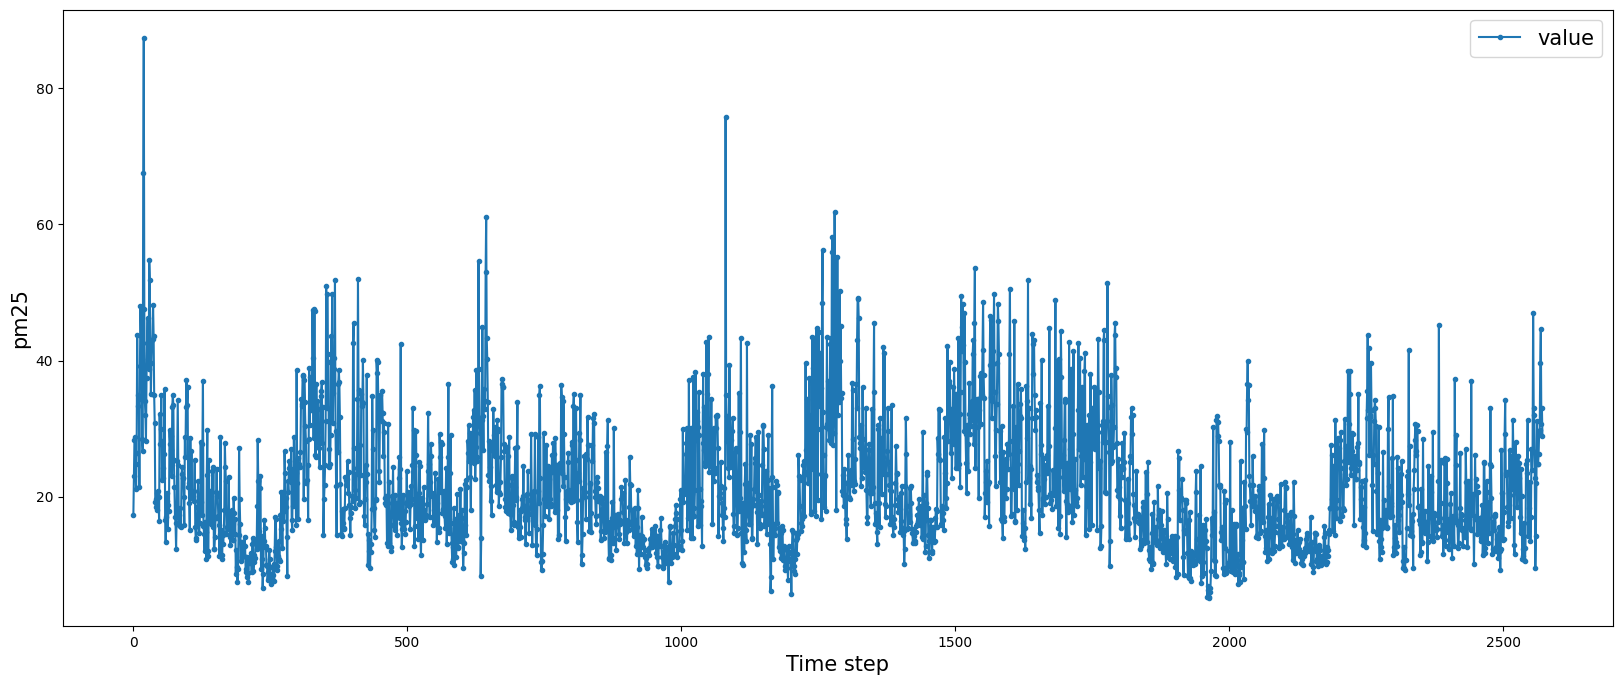

In [24]:
plot_1_data(data=y_aod, datalabel="value", xlabel="Time step", ylabel="pm25")

### Data normalization

In [25]:
# Scaled features
aod_features_scaler = MinMaxScaler()
X_aod_scaled = aod_features_scaler.fit_transform(X_aod)
X_aod_scaled = pd.DataFrame(X_aod_scaled, columns=X_aod.columns)
X_aod_scaled

,lat,lon,station,pop,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,pm25_3km,rh,tmp,wspd,aod,hpbl
0,0.326794,0.466551,0.0,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.401465,0.265635,0.292466,0.485894,0.175961,0.382113
1,0.326794,0.466551,0.0,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.625275,0.257407,0.259187,0.251463,0.175961,0.355779
2,0.326794,0.466551,0.0,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.628327,0.285912,0.389039,0.161190,0.175961,0.311726
3,0.326794,0.466551,0.0,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.685226,0.275348,0.474896,0.111222,0.175961,0.423568
4,0.326794,0.466551,0.0,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.787668,0.281302,0.464230,0.350381,0.175961,0.461837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568,0.306899,0.237227,1.0,1.00000,1.000000,0.323578,0.075528,0.62963,0.788964,0.0,0.170886,0.308772,0.0,0.085003,0.354083,0.567964,0.125557,0.182122,0.160199,0.302546
2569,0.306899,0.237227,1.0,1.00000,1.000000,0.323578,0.075528,0.62963,0.788964,0.0,0.170886,0.308772,0.0,0.085003,0.297906,0.377335,0.289650,0.240136,0.160199,0.446013
2570,0.306899,0.237227,1.0,1.00000,1.000000,0.323578,0.075528,0.62963,0.788964,0.0,0.170886,0.308772,0.0,0.085003,0.280963,0.412632,0.289348,0.343407,0.046031,0.584396
2571,0.306899,0.237227,1.0,1.00000,1.000000,0.323578,0.075528,0.62963,0.788964,0.0,0.170886,0.308772,0.0,0.085003,0.176000,0.362385,0.206556,0.553589,0.160199,0.473268


In [26]:
# Scaled features without pm25_3km
aod_features_no_pm25_3km_scaler = MinMaxScaler()
X_aod_no_pm25_3km_scaled = aod_features_no_pm25_3km_scaler.fit_transform(X_aod_no_pm25_3km)
X_aod_no_pm25_3km_scaled = pd.DataFrame(X_aod_no_pm25_3km_scaled, columns=X_aod_no_pm25_3km.columns)
X_aod_no_pm25_3km_scaled

,lat,lon,station,pop,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,rh,tmp,wspd,aod,hpbl
0,0.326794,0.466551,0.0,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.265635,0.292466,0.485894,0.175961,0.382113
1,0.326794,0.466551,0.0,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.257407,0.259187,0.251463,0.175961,0.355779
2,0.326794,0.466551,0.0,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.285912,0.389039,0.161190,0.175961,0.311726
3,0.326794,0.466551,0.0,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.275348,0.474896,0.111222,0.175961,0.423568
4,0.326794,0.466551,0.0,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.281302,0.464230,0.350381,0.175961,0.461837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568,0.306899,0.237227,1.0,1.00000,1.000000,0.323578,0.075528,0.62963,0.788964,0.0,0.170886,0.308772,0.0,0.085003,0.567964,0.125557,0.182122,0.160199,0.302546
2569,0.306899,0.237227,1.0,1.00000,1.000000,0.323578,0.075528,0.62963,0.788964,0.0,0.170886,0.308772,0.0,0.085003,0.377335,0.289650,0.240136,0.160199,0.446013
2570,0.306899,0.237227,1.0,1.00000,1.000000,0.323578,0.075528,0.62963,0.788964,0.0,0.170886,0.308772,0.0,0.085003,0.412632,0.289348,0.343407,0.046031,0.584396
2571,0.306899,0.237227,1.0,1.00000,1.000000,0.323578,0.075528,0.62963,0.788964,0.0,0.170886,0.308772,0.0,0.085003,0.362385,0.206556,0.553589,0.160199,0.473268


In [27]:
# Scaled label
aod_label_scaler = MinMaxScaler(feature_range=(0, 1))
y_aod_scaled = aod_label_scaler.fit_transform(y_aod)
y_aod_scaled = pd.DataFrame(y_aod_scaled, columns=y_aod.columns)
y_aod_scaled

,pm25
0,0.147032
1,0.216931
2,0.281258
3,0.287336
4,0.239218
...,...
2568,0.419453
2569,0.480472
2570,0.310835
2571,0.339606


## Dimensionality Reduction Comparation

To compare the effect of each method, we will do the following things:
* Use the pm25 as the label
* Use other columns as the input features
* Reduce the dimension of input data using above methods
* Pass the processed input data to a model (e.g. LSTM, ...)

### Evaluation board

In [28]:
evaluation_board = {'with_pm25_3km': [], 'dim_reduction_method': [], 'dim_after_reduction': [], 'prediction':[], 'mae': []}

### Range of dimension

In [29]:
RANGE_OF_DIMENSION = range(conf["reduction"]["min_number_of_features"], X_aod_scaled.shape[1])
for n in RANGE_OF_DIMENSION:
  print(n, end=' ')

15 16 17 18 19 

### Prediction + LSTM-Seq2Seq

#### Doing the loop

In [30]:
loopresults = {i:{"mae": None, "encoded_data": None, "evaluation_data": None, "encoder_model_path": None} for i in RANGE_OF_DIMENSION}

# Loop between min and (number of features - 1) to choose what number is the best
for n in RANGE_OF_DIMENSION:
    # Apply Seq2seq
    lstms2s = LSTMSeq2SeqReduction(X_aod_scaled,
                               test_percentage=0.2,
                               latent_dim=n,
                               n_past=conf["reduction"]["n_past"], n_future=conf["reduction"]["n_future"],
                               epochs=conf["reduction"]["epochs"], batch_size=conf["reduction"]["batch_size"],
                               verbose=0,
                               model_name=f"aod_lstms2s_dim_reduction_{n}_features")
    X_aod_scaled_lstm_s2s_encoded, encoder_model_path = lstms2s.execute()

    lstms2s.get_model_info()
    lstms2s.get_encoder_model_info()

    # Prediction
    y_pred, y_test = predictLSTM(X_aod_scaled_lstm_s2s_encoded, y_aod_scaled,
                                n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                                epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                                model_name=f"aod_lstm_prediction_with_lstms2s_dim_reduction_{n}_features",
                                verbose=0)

    # Evaluation
    all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, aod_label_scaler, verbose=0)

    # Logging
    loopresults[n]["mae"] = avg_mae
    loopresults[n]["encoded_data"] = X_aod_scaled_lstm_s2s_encoded
    loopresults[n]["encoder_model_path"] = encoder_model_path
    loopresults[n]["evaluation_data"] = (all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae)

I0000 00:00:1752825644.320851 1096396 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 849 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:89:00.0, compute capability: 8.0
I0000 00:00:1752825651.424013 1096636 service.cc:152] XLA service 0x10b608b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752825651.424038 1096636 service.cc:160]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
I0000 00:00:1752825652.490092 1096636 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752825654.537510 1096636 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "aod_lstms2s_dim_reduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 7, 100)    │     48,400 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 50),      │     30,200 │ lstm[0][0]        │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 15)        │        765 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 7, 15)     │          0 │ dense[0][0]       │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 7, 50)     │     13,200 │ repeat_vector[0]… │
│                     │                   │            │ lstm_1[0][1],     │
│                     │                   │            │ lstm_1[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 7, 100)    │     60,400 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 7, 20)     │      2,020 │ lstm_3[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 464,957 (1.77 MB)

 Trainable params: 154,985 (605.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 309,972 (1.18 MB)

None


Model: "aod_lstms2s_dim_reduction_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,365 (310.02 KB)

 Trainable params: 79,365 (310.02 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstms2s_dim_reduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 7, 100)    │     48,400 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ [(None, 50),      │     30,200 │ lstm_6[0][0]      │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │        816 │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 7, 16)     │          0 │ dense_4[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 7, 50)     │     13,400 │ repeat_vector_2[… │
│                     │                   │            │ lstm_7[0][1],     │
│                     │                   │            │ lstm_7[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 7, 100)    │     60,400 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 7, 20)     │      2,020 │ lstm_9[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 465,710 (1.78 MB)

 Trainable params: 155,236 (606.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 310,474 (1.18 MB)

None


Model: "aod_lstms2s_dim_reduction_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,416 (310.22 KB)

 Trainable params: 79,416 (310.22 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstms2s_dim_reduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 7, 100)    │     48,400 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_12[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 17)        │        867 │ lstm_13[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_4     │ (None, 7, 17)     │          0 │ dense_8[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 7, 50)     │     13,600 │ repeat_vector_4[… │
│                     │                   │            │ lstm_13[0][1],    │
│                     │                   │            │ lstm_13[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_14[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_6  │ (None, 7, 20)     │      2,020 │ lstm_15[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 466,463 (1.78 MB)

 Trainable params: 155,487 (607.37 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 310,976 (1.19 MB)

None


Model: "aod_lstms2s_dim_reduction_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,467 (310.42 KB)

 Trainable params: 79,467 (310.42 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstms2s_dim_reduction_18_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ (None, 7, 100)    │     48,400 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_18[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 18)        │        918 │ lstm_19[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_6     │ (None, 7, 18)     │          0 │ dense_12[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_20 (LSTM)      │ (None, 7, 50)     │     13,800 │ repeat_vector_6[… │
│                     │                   │            │ lstm_19[0][1],    │
│                     │                   │            │ lstm_19[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_21 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_20[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, 7, 20)     │      2,020 │ lstm_21[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 467,216 (1.78 MB)

 Trainable params: 155,738 (608.35 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 311,478 (1.19 MB)

None


Model: "aod_lstms2s_dim_reduction_18_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 18)             │           918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,518 (310.62 KB)

 Trainable params: 79,518 (310.62 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstms2s_dim_reduction_19_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_24 (LSTM)      │ (None, 7, 100)    │     48,400 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_25 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_24[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 19)        │        969 │ lstm_25[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_8     │ (None, 7, 19)     │          0 │ dense_16[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_26 (LSTM)      │ (None, 7, 50)     │     14,000 │ repeat_vector_8[… │
│                     │                   │            │ lstm_25[0][1],    │
│                     │                   │            │ lstm_25[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_27 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_26[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_12 │ (None, 7, 20)     │      2,020 │ lstm_27[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 467,969 (1.79 MB)

 Trainable params: 155,989 (609.33 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 311,980 (1.19 MB)

None


Model: "aod_lstms2s_dim_reduction_19_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 19)             │           969 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,569 (310.82 KB)

 Trainable params: 79,569 (310.82 KB)

 Non-trainable params: 0 (0.00 B)

None


N = 15 - MAE = 6.262347008000192
N = 16 - MAE = 5.582113909803294
N = 17 - MAE = 4.823585602555695
N = 18 - MAE = 4.556786759601829
N = 19 - MAE = 6.614908056338853


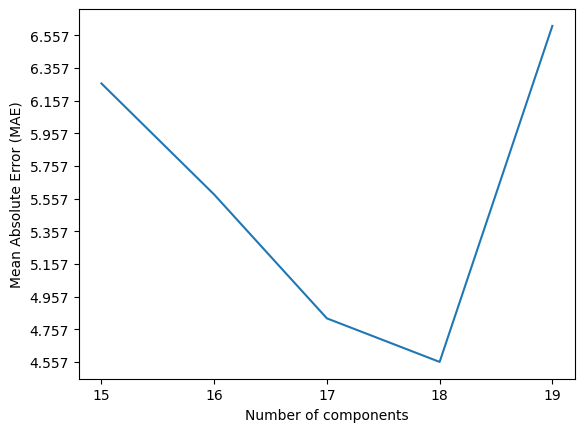

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


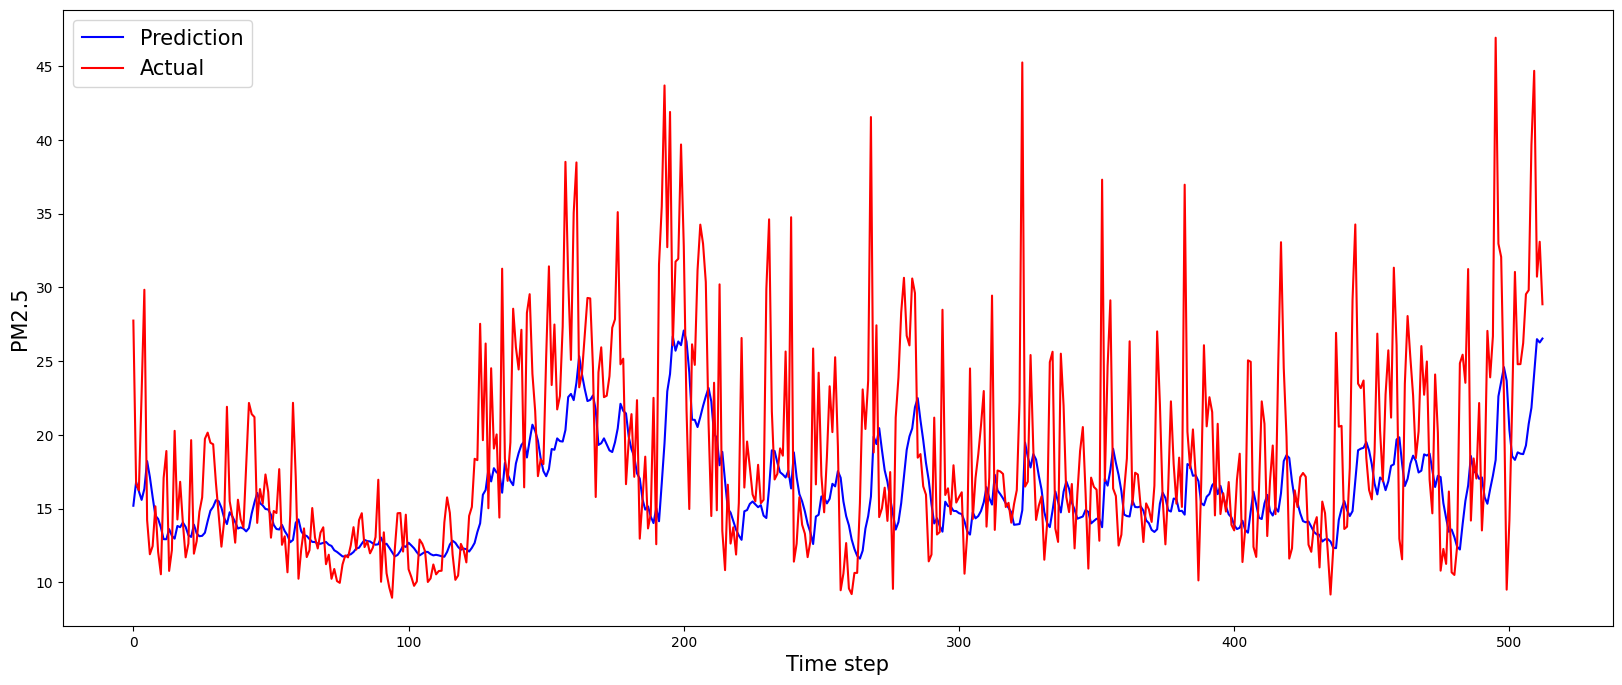

,with_pm25_3km,dim_reduction_method,dim_after_reduction,prediction,mae
0,Yes,LSTM-Seq2Seq,18,LSTM,4.556787


In [31]:
# Print out the number of features and corresponding MAE
for n in loopresults.keys():
    print(f"N = {n} - MAE = {loopresults[n]['mae']}")

# Visualize the relation between number of features and MAE
values = [loopresults[n]["mae"] for n in RANGE_OF_DIMENSION]
plt.plot(RANGE_OF_DIMENSION, values)
plt.xticks(RANGE_OF_DIMENSION)
plt.xlabel("Number of components")
plt.yticks(np.arange(min(values), max(values) + 0.1, 0.2))
plt.ylabel("Mean Absolute Error (MAE)")
plt.show()

# Choose the best number of features
best_mae, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = 1000, 0, None, None, None
for n in loopresults.keys():
    if loopresults[n]["mae"] < best_mae:
        best_num_of_components = n
        best_mae = loopresults[n]["mae"]
        best_encoded_data = loopresults[n]["encoded_data"]
        best_evaluation_data = loopresults[n]["evaluation_data"]
        best_encoder_model_path = loopresults[n]["encoder_model_path"]

# Visualize the prediction
all_days_inv_y_pred, all_days_inv_y_test, _, _ = best_evaluation_data
for day in range(conf["prediction"]["n_future"]):
    inv_y_pred = all_days_inv_y_pred[day,:,:]
    inv_y_test = all_days_inv_y_test[day,:,:]
    print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
    plot_2_data(data1=inv_y_pred,
                data2=inv_y_test,
                datalabel1="Prediction",
                datalabel2="Actual",
                xlabel="Time step",
                ylabel="PM2.5")

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["LSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]
evaluation_board['with_pm25_3km'] += ["Yes"]
pd.DataFrame(evaluation_board)

#### Prepare reduced data

In [32]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_lstms2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_lstms2s_reduced.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_lstms2s_reduced_2021_2022.csv"))
df_lstms2s_reduced

,aod_feature_1,aod_feature_2,aod_feature_3,aod_feature_4,aod_feature_5,aod_feature_6,aod_feature_7,aod_feature_8,aod_feature_9,aod_feature_10,aod_feature_11,aod_feature_12,aod_feature_13,aod_feature_14,aod_feature_15,aod_feature_16,aod_feature_17,aod_feature_18,station
time,,,,,,,,,,,,,,,,,,,
2021-01-01,-0.063893,-0.888072,-0.016788,0.028726,0.129592,0.181458,0.037677,0.501425,-0.478962,0.079657,-0.609621,0.211925,0.335851,-0.048941,-0.225357,0.335628,-0.265181,-0.078221,201
2021-01-02,-0.063893,-0.888072,-0.016788,0.028726,0.129592,0.181458,0.037677,0.501425,-0.478962,0.079657,-0.609621,0.211925,0.335851,-0.048941,-0.225357,0.335628,-0.265181,-0.078221,201
2021-01-03,-0.063488,-0.886277,-0.017226,0.028266,0.131020,0.181259,0.037101,0.500945,-0.477822,0.078643,-0.609770,0.212933,0.334923,-0.049232,-0.225052,0.336249,-0.264721,-0.078539,201
2021-01-04,-0.062140,-0.883686,-0.018362,0.027120,0.133265,0.180572,0.036898,0.500612,-0.476665,0.078678,-0.610720,0.214079,0.333268,-0.049538,-0.224187,0.337279,-0.264478,-0.079026,201
2021-01-05,-0.060250,-0.881575,-0.020324,0.026451,0.136342,0.178584,0.037753,0.501586,-0.476599,0.080073,-0.612880,0.215094,0.331835,-0.050859,-0.223265,0.337810,-0.263783,-0.080038,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,0.060881,-0.550532,-0.385914,0.163463,0.149512,-0.109391,-0.074167,0.304030,-0.239969,0.191119,-0.772819,0.092904,0.315826,-0.391945,-0.539535,-0.384634,-0.241266,0.242112,216
2022-12-28,0.059431,-0.548406,-0.382029,0.162440,0.148015,-0.108940,-0.074402,0.301949,-0.239481,0.190249,-0.767813,0.092920,0.313821,-0.388712,-0.536549,-0.381309,-0.239229,0.240330,216
2022-12-29,0.056392,-0.544696,-0.376780,0.160428,0.146966,-0.109282,-0.076280,0.300236,-0.238724,0.189526,-0.759600,0.092349,0.310424,-0.386729,-0.531226,-0.379234,-0.237111,0.239789,216


#### Doing the loop (no pm25_3km)

In [33]:
loopresults = {i:{"mae": None, "encoded_data": None, "evaluation_data": None, "encoder_model_path": None} for i in RANGE_OF_DIMENSION}

# Loop between min and (number of features - 1) to choose what number is the best
for n in RANGE_OF_DIMENSION:
    # Apply Seq2seq
    lstms2s = LSTMSeq2SeqReduction(X_aod_no_pm25_3km_scaled,
                                   test_percentage=0.2,
                                   latent_dim=n,
                                   n_past=conf["reduction"]["n_past"], n_future=conf["reduction"]["n_future"],
                                   epochs=conf["reduction"]["epochs"], batch_size=conf["reduction"]["batch_size"],
                                   verbose=0,
                                   model_name=f"aod_lstms2s_dim_reduction_{n}_features_no_pm25_3km")
    X_aod_no_pm25_3km_scaled_lstm_s2s_encoded, encoder_model_path = lstms2s.execute()

    lstms2s.get_model_info()
    lstms2s.get_encoder_model_info()

    # Prediction
    y_pred, y_test = predictLSTM(X_aod_no_pm25_3km_scaled_lstm_s2s_encoded, y_aod_scaled,
                                n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                                epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                                model_name=f"aod_lstm_prediction_with_lstms2s_dim_reduction_{n}_features_no_pm25_3km",
                                verbose=0)

    # Evaluation
    all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, aod_label_scaler, verbose=0)

    # Logging
    loopresults[n]["mae"] = avg_mae
    loopresults[n]["encoded_data"] = X_aod_no_pm25_3km_scaled_lstm_s2s_encoded
    loopresults[n]["encoder_model_path"] = encoder_model_path
    loopresults[n]["evaluation_data"] = (all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae)

Model: "aod_lstms2s_dim_reduction_15_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_30 (LSTM)      │ (None, 7, 100)    │     48,000 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_31 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_30[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 15)        │        765 │ lstm_31[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_10    │ (None, 7, 15)     │          0 │ dense_20[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_32 (LSTM)      │ (None, 7, 50)     │     13,200 │ repeat_vector_10… │
│                     │                   │            │ lstm_31[0][1],    │
│                     │                   │            │ lstm_31[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_33 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_32[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_15 │ (None, 7, 19)     │      1,919 │ lstm_33[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 463,454 (1.77 MB)

 Trainable params: 154,484 (603.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 308,970 (1.18 MB)

None


Model: "aod_lstms2s_dim_reduction_15_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 7, 100)         │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,965 (308.46 KB)

 Trainable params: 78,965 (308.46 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstms2s_dim_reduction_16_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_36 (LSTM)      │ (None, 7, 100)    │     48,000 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_37 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_36[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 16)        │        816 │ lstm_37[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_12    │ (None, 7, 16)     │          0 │ dense_24[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_38 (LSTM)      │ (None, 7, 50)     │     13,400 │ repeat_vector_12… │
│                     │                   │            │ lstm_37[0][1],    │
│                     │                   │            │ lstm_37[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_39 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_38[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_18 │ (None, 7, 19)     │      1,919 │ lstm_39[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 464,207 (1.77 MB)

 Trainable params: 154,735 (604.43 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 309,472 (1.18 MB)

None


Model: "aod_lstms2s_dim_reduction_16_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 7, 100)         │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,016 (308.66 KB)

 Trainable params: 79,016 (308.66 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstms2s_dim_reduction_17_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_42 (LSTM)      │ (None, 7, 100)    │     48,000 │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_43 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_42[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 17)        │        867 │ lstm_43[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_14    │ (None, 7, 17)     │          0 │ dense_28[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_44 (LSTM)      │ (None, 7, 50)     │     13,600 │ repeat_vector_14… │
│                     │                   │            │ lstm_43[0][1],    │
│                     │                   │            │ lstm_43[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_45 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_44[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_21 │ (None, 7, 19)     │      1,919 │ lstm_45[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 464,960 (1.77 MB)

 Trainable params: 154,986 (605.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 309,974 (1.18 MB)

None


Model: "aod_lstms2s_dim_reduction_17_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ (None, 7, 100)         │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,067 (308.86 KB)

 Trainable params: 79,067 (308.86 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstms2s_dim_reduction_18_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_48 (LSTM)      │ (None, 7, 100)    │     48,000 │ input_layer_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_49 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_48[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 18)        │        918 │ lstm_49[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_16    │ (None, 7, 18)     │          0 │ dense_32[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_50 (LSTM)      │ (None, 7, 50)     │     13,800 │ repeat_vector_16… │
│                     │                   │            │ lstm_49[0][1],    │
│                     │                   │            │ lstm_49[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_51 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_50[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_24 │ (None, 7, 19)     │      1,919 │ lstm_51[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 465,713 (1.78 MB)

 Trainable params: 155,237 (606.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 310,476 (1.18 MB)

None


Model: "aod_lstms2s_dim_reduction_18_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_48 (LSTM)                  │ (None, 7, 100)         │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 18)             │           918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,118 (309.05 KB)

 Trainable params: 79,118 (309.05 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstms2s_dim_reduction_19_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_54 (LSTM)      │ (None, 7, 100)    │     48,000 │ input_layer_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_55 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_54[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 19)        │        969 │ lstm_55[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_18    │ (None, 7, 19)     │          0 │ dense_36[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_56 (LSTM)      │ (None, 7, 50)     │     14,000 │ repeat_vector_18… │
│                     │                   │            │ lstm_55[0][1],    │
│                     │                   │            │ lstm_55[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_57 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_56[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_27 │ (None, 7, 19)     │      1,919 │ lstm_57[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 466,466 (1.78 MB)

 Trainable params: 155,488 (607.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 310,978 (1.19 MB)

None


Model: "aod_lstms2s_dim_reduction_19_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_54 (LSTM)                  │ (None, 7, 100)         │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 19)             │           969 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,169 (309.25 KB)

 Trainable params: 79,169 (309.25 KB)

 Non-trainable params: 0 (0.00 B)

None


N = 15 - MAE = 4.904461081507876
N = 16 - MAE = 4.801179494727823
N = 17 - MAE = 4.515588775889192
N = 18 - MAE = 5.061555164385981
N = 19 - MAE = 4.9414603770104035


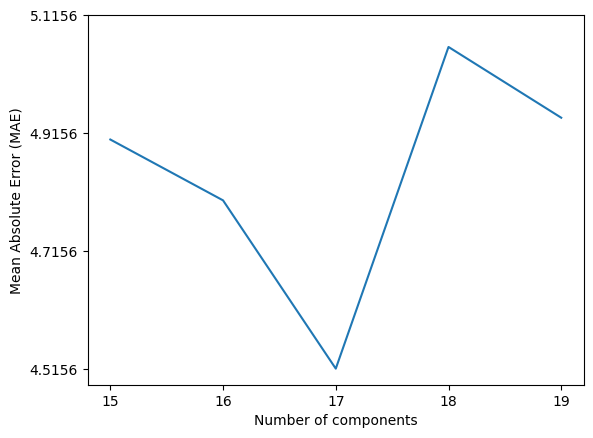

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


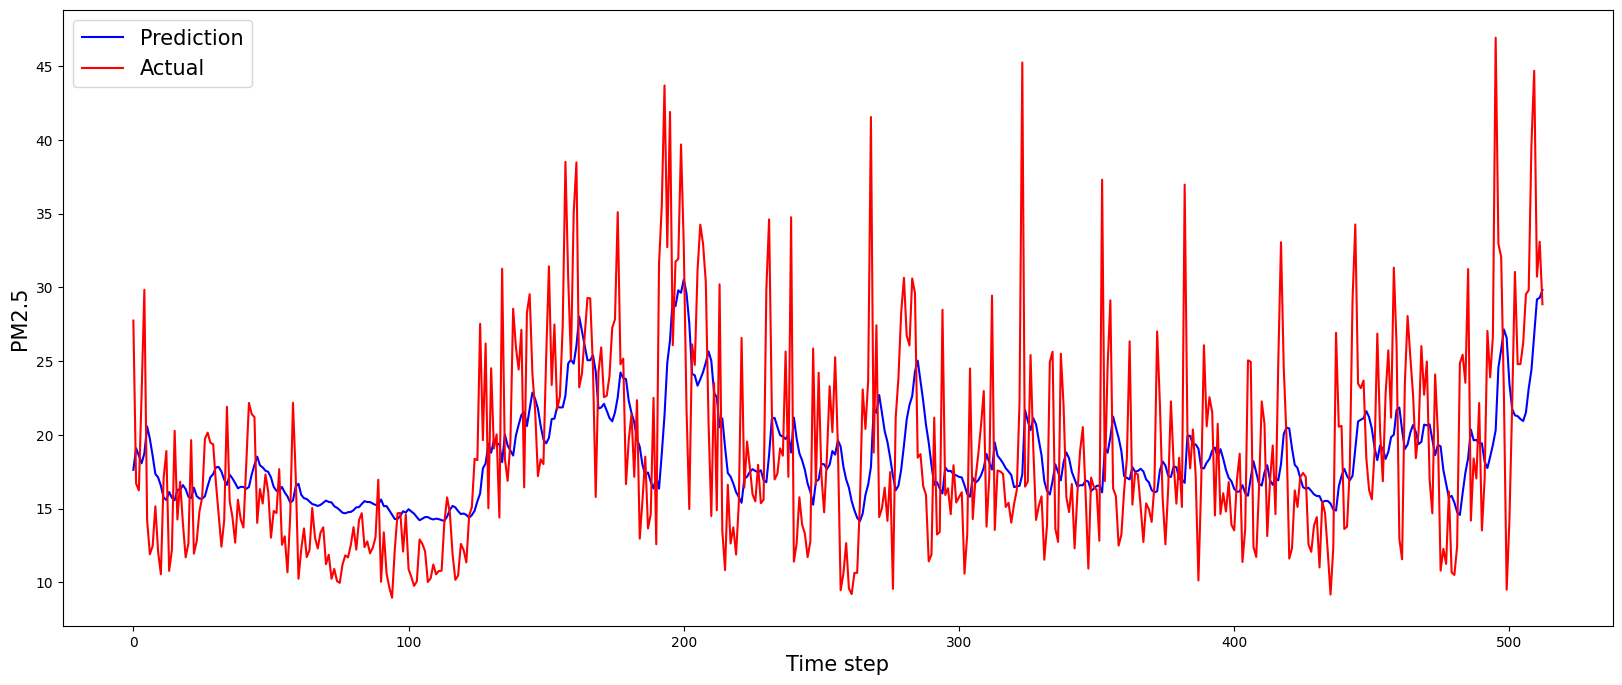

,with_pm25_3km,dim_reduction_method,dim_after_reduction,prediction,mae
0,Yes,LSTM-Seq2Seq,18,LSTM,4.556787
1,No,LSTM-Seq2Seq,17,LSTM,4.515589


In [34]:
# Print out the number of features and corresponding MAE
for n in loopresults.keys():
    print(f"N = {n} - MAE = {loopresults[n]['mae']}")

# Visualize the relation between number of features and MAE
values = [loopresults[n]["mae"] for n in RANGE_OF_DIMENSION]
plt.plot(RANGE_OF_DIMENSION, values)
plt.xticks(RANGE_OF_DIMENSION)
plt.xlabel("Number of components")
plt.yticks(np.arange(min(values), max(values) + 0.1, 0.2))
plt.ylabel("Mean Absolute Error (MAE)")
plt.show()

# Choose the best number of features
best_mae, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = 1000, 0, None, None, None
for n in loopresults.keys():
    if loopresults[n]["mae"] < best_mae:
        best_num_of_components = n
        best_mae = loopresults[n]["mae"]
        best_encoded_data = loopresults[n]["encoded_data"]
        best_evaluation_data = loopresults[n]["evaluation_data"]
        best_encoder_model_path = loopresults[n]["encoder_model_path"]

# Visualize the prediction
all_days_inv_y_pred, all_days_inv_y_test, _, _ = best_evaluation_data
for day in range(conf["prediction"]["n_future"]):
    inv_y_pred = all_days_inv_y_pred[day,:,:]
    inv_y_test = all_days_inv_y_test[day,:,:]
    print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
    plot_2_data(data1=inv_y_pred,
                data2=inv_y_test,
                datalabel1="Prediction",
                datalabel2="Actual",
                xlabel="Time step",
                ylabel="PM2.5")

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["LSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]
evaluation_board['with_pm25_3km'] += ["No"]
pd.DataFrame(evaluation_board)

#### Prepare reduced data (no pm25_3km)

In [35]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_lstms2s_reduced_no_pm25_3km = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_lstms2s_reduced_no_pm25_3km.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_lstms2s_reduced_2021_2022_no_pm25_3km.csv"))
df_lstms2s_reduced_no_pm25_3km

,aod_feature_1,aod_feature_2,aod_feature_3,aod_feature_4,aod_feature_5,aod_feature_6,aod_feature_7,aod_feature_8,aod_feature_9,aod_feature_10,aod_feature_11,aod_feature_12,aod_feature_13,aod_feature_14,aod_feature_15,aod_feature_16,aod_feature_17,station
time,,,,,,,,,,,,,,,,,,
2021-01-01,0.103929,-0.270888,0.213883,0.213058,-0.998515,-0.119761,0.405255,0.273416,0.476966,0.671724,-0.300250,0.045065,-0.145949,0.314818,-0.415694,-0.779252,0.092707,201
2021-01-02,0.103929,-0.270888,0.213883,0.213058,-0.998515,-0.119761,0.405255,0.273416,0.476966,0.671724,-0.300250,0.045065,-0.145949,0.314818,-0.415694,-0.779252,0.092707,201
2021-01-03,0.102928,-0.272341,0.213993,0.214242,-0.996899,-0.120709,0.404949,0.272632,0.476613,0.671465,-0.300593,0.045267,-0.143089,0.314171,-0.413965,-0.778523,0.094499,201
2021-01-04,0.102025,-0.272867,0.213509,0.215811,-0.992756,-0.121418,0.405235,0.274080,0.475476,0.669335,-0.299629,0.046788,-0.140033,0.312685,-0.411100,-0.777128,0.096178,201
2021-01-05,0.101271,-0.273454,0.212729,0.216632,-0.986940,-0.121924,0.405182,0.276215,0.474354,0.666302,-0.297592,0.050022,-0.137119,0.311509,-0.406744,-0.774814,0.097706,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,-0.058664,0.059828,0.247573,-0.226979,-0.179732,-0.227590,-0.463666,0.127626,-0.200010,0.614727,-0.015546,0.927030,0.273672,-0.163466,-0.043682,0.136474,-0.091145,216
2022-12-28,-0.059715,0.060831,0.246255,-0.227137,-0.179446,-0.226510,-0.461893,0.127257,-0.198513,0.611948,-0.016131,0.922520,0.273839,-0.165205,-0.042267,0.134136,-0.090387,216
2022-12-29,-0.061441,0.063234,0.245490,-0.226763,-0.177552,-0.225621,-0.461381,0.127430,-0.198286,0.607860,-0.015796,0.919667,0.273652,-0.166374,-0.040546,0.133924,-0.091384,216


### Prediction + GRU-Seq2Seq

#### Doing the loop

In [36]:
loopresults = {i:{"mae": None, "encoded_data": None, "evaluation_data": None, "encoder_model_path": None} for i in RANGE_OF_DIMENSION}

# Loop between min and (number of features - 1) to choose what number is the best
for n in RANGE_OF_DIMENSION:
    # Apply Seq2seq
    grus2s = GRUSeq2SeqReduction(X_aod_scaled,
                                 test_percentage=0.2,
                                 latent_dim=n,
                                 n_past=conf["reduction"]["n_past"], n_future = conf["reduction"]["n_future"],
                                 epochs=conf["reduction"]["epochs"], batch_size=conf["reduction"]["batch_size"],
                                 verbose=0,
                                 model_name=f"aod_grus2s_dim_reduction_{n}_features")
    X_aod_scaled_grus2s_encoded, encoder_model_path = grus2s.execute()

    grus2s.get_model_info()
    grus2s.get_encoder_model_info()

    # Prediction
    y_pred, y_test = predictLSTM(X_aod_scaled_grus2s_encoded, y_aod_scaled,
                               n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                               epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                               model_name=f"aod_lstm_prediction_with_grus2s_dim_reduction_{n}_features",
                               verbose=0)

    # Evaluation
    all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, aod_label_scaler, verbose=0)

    # Logging
    print(f"N = {n} - MAE = {avg_mae}")
    loopresults[n]["mae"] = avg_mae
    loopresults[n]["encoded_data"] = X_aod_scaled_grus2s_encoded
    loopresults[n]["encoder_model_path"] = encoder_model_path
    loopresults[n]["evaluation_data"] = (all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae)

Model: "aod_grus2s_dim_reduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 7, 100)    │     36,600 │ input_layer_30[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ [(None, 50),      │     22,800 │ gru[0][0]         │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 15)        │        765 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_20    │ (None, 7, 15)     │          0 │ dense_40[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 7, 50)     │     10,050 │ repeat_vector_20… │
│                     │                   │            │ gru_1[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 7, 100)    │     45,600 │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_30 │ (None, 7, 20)     │      2,020 │ gru_3[0][0]       │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 353,507 (1.35 MB)

 Trainable params: 117,835 (460.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,672 (920.60 KB)

None


Model: "aod_grus2s_dim_reduction_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 7, 100)         │        36,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,165 (235.02 KB)

 Trainable params: 60,165 (235.02 KB)

 Non-trainable params: 0 (0.00 B)

None
N = 15 - MAE = 4.794344999727221


Model: "aod_grus2s_dim_reduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ (None, 7, 100)    │     36,600 │ input_layer_33[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ [(None, 50),      │     22,800 │ gru_4[0][0]       │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 16)        │        816 │ gru_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_22    │ (None, 7, 16)     │          0 │ dense_44[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_6 (GRU)         │ (None, 7, 50)     │     10,200 │ repeat_vector_22… │
│                     │                   │            │ gru_5[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_7 (GRU)         │ (None, 7, 100)    │     45,600 │ gru_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_33 │ (None, 7, 20)     │      2,020 │ gru_7[0][0]       │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 354,110 (1.35 MB)

 Trainable params: 118,036 (461.08 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 236,074 (922.17 KB)

None


Model: "aod_grus2s_dim_reduction_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 7, 100)         │        36,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,216 (235.22 KB)

 Trainable params: 60,216 (235.22 KB)

 Non-trainable params: 0 (0.00 B)

None
N = 16 - MAE = 4.422616963794244


Model: "aod_grus2s_dim_reduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_8 (GRU)         │ (None, 7, 100)    │     36,600 │ input_layer_36[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_9 (GRU)         │ [(None, 50),      │     22,800 │ gru_8[0][0]       │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 17)        │        867 │ gru_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_24    │ (None, 7, 17)     │          0 │ dense_48[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_10 (GRU)        │ (None, 7, 50)     │     10,350 │ repeat_vector_24… │
│                     │                   │            │ gru_9[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_11 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_36 │ (None, 7, 20)     │      2,020 │ gru_11[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 354,713 (1.35 MB)

 Trainable params: 118,237 (461.86 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 236,476 (923.74 KB)

None


Model: "aod_grus2s_dim_reduction_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_37 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 7, 100)         │        36,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,267 (235.42 KB)

 Trainable params: 60,267 (235.42 KB)

 Non-trainable params: 0 (0.00 B)

None
N = 17 - MAE = 4.204150848706821


Model: "aod_grus2s_dim_reduction_18_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_39      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_12 (GRU)        │ (None, 7, 100)    │     36,600 │ input_layer_39[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_13 (GRU)        │ [(None, 50),      │     22,800 │ gru_12[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_52 (Dense)    │ (None, 18)        │        918 │ gru_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_26    │ (None, 7, 18)     │          0 │ dense_52[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_14 (GRU)        │ (None, 7, 50)     │     10,500 │ repeat_vector_26… │
│                     │                   │            │ gru_13[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_15 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_39 │ (None, 7, 20)     │      2,020 │ gru_15[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 355,316 (1.36 MB)

 Trainable params: 118,438 (462.65 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 236,878 (925.31 KB)

None


Model: "aod_grus2s_dim_reduction_18_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_40 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_12 (GRU)                    │ (None, 7, 100)         │        36,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_13 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 18)             │           918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,318 (235.62 KB)

 Trainable params: 60,318 (235.62 KB)

 Non-trainable params: 0 (0.00 B)

None
N = 18 - MAE = 4.389174952828622


Model: "aod_grus2s_dim_reduction_19_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_42      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_16 (GRU)        │ (None, 7, 100)    │     36,600 │ input_layer_42[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_17 (GRU)        │ [(None, 50),      │     22,800 │ gru_16[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_56 (Dense)    │ (None, 19)        │        969 │ gru_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_28    │ (None, 7, 19)     │          0 │ dense_56[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_18 (GRU)        │ (None, 7, 50)     │     10,650 │ repeat_vector_28… │
│                     │                   │            │ gru_17[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_19 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_42 │ (None, 7, 20)     │      2,020 │ gru_19[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 355,919 (1.36 MB)

 Trainable params: 118,639 (463.43 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 237,280 (926.88 KB)

None


Model: "aod_grus2s_dim_reduction_19_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_43 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_16 (GRU)                    │ (None, 7, 100)         │        36,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_17 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 19)             │           969 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,369 (235.82 KB)

 Trainable params: 60,369 (235.82 KB)

 Non-trainable params: 0 (0.00 B)

None
N = 19 - MAE = 4.7340685438648435


N = 15 - MAE = 4.794344999727221
N = 16 - MAE = 4.422616963794244
N = 17 - MAE = 4.204150848706821
N = 18 - MAE = 4.389174952828622
N = 19 - MAE = 4.7340685438648435


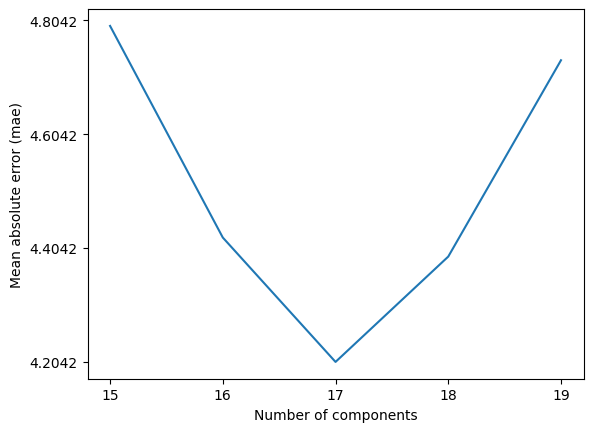

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


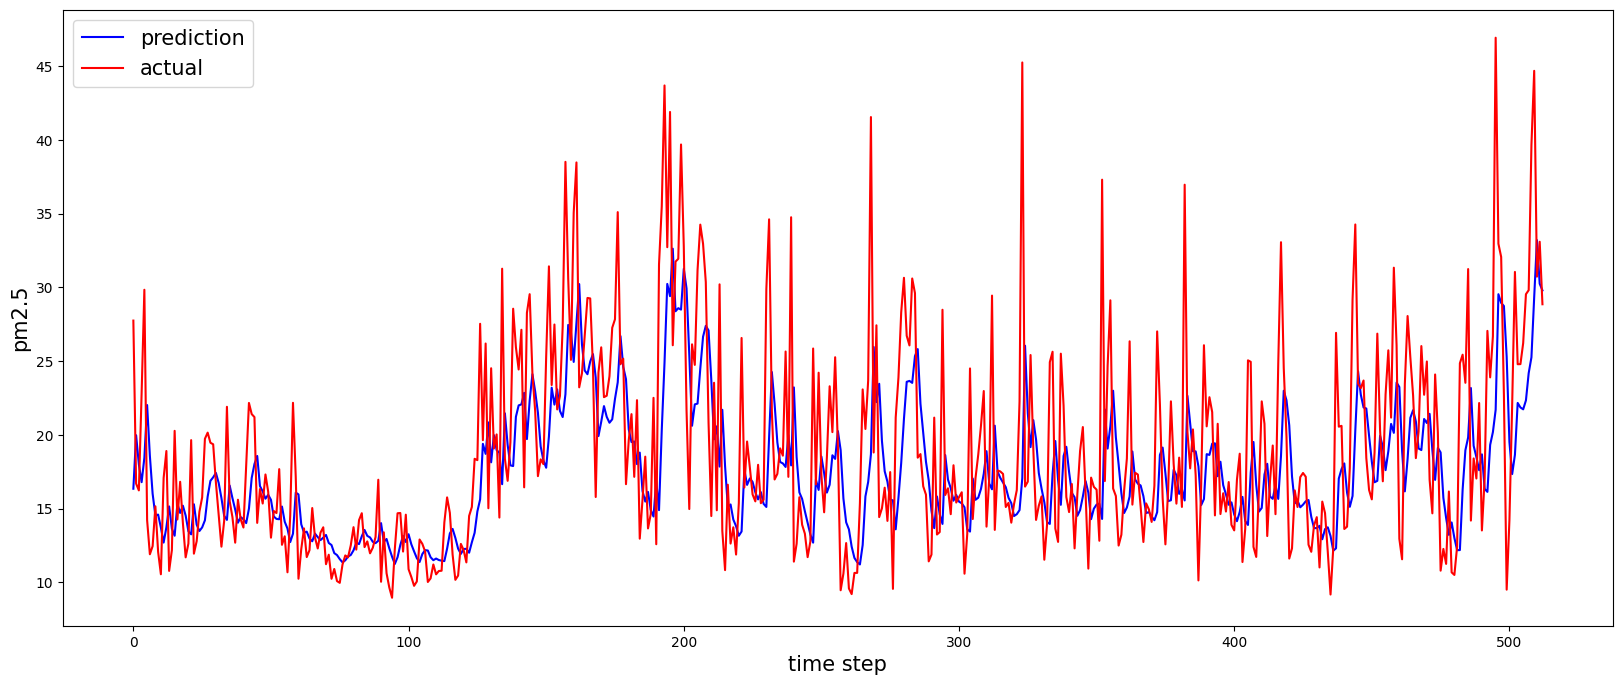

,with_pm25_3km,dim_reduction_method,dim_after_reduction,prediction,mae
0,Yes,LSTM-Seq2Seq,18,LSTM,4.556787
1,No,LSTM-Seq2Seq,17,LSTM,4.515589
2,yes,GRU-Seq2Seq,17,LSTM,4.204151


In [37]:
# Print out the number of features and corresponding mae
for n in loopresults.keys():
    print(f"N = {n} - MAE = {loopresults[n]['mae']}")

# visualize the relation between number of features and mae
values = [loopresults[n]["mae"] for n in RANGE_OF_DIMENSION]
plt.plot(RANGE_OF_DIMENSION, values)
plt.xticks(RANGE_OF_DIMENSION)
plt.xlabel("Number of components")
plt.yticks(np.arange(min(values), max(values) + 0.1, 0.2))
plt.ylabel("Mean absolute error (mae)")
plt.show()

# Choose the best number of features
best_mae, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = 1000, 0, None, None, None
for n in loopresults.keys():
    if loopresults[n]["mae"] < best_mae:
        best_num_of_components = n
        best_mae = loopresults[n]["mae"]
        best_encoded_data = loopresults[n]["encoded_data"]
        best_evaluation_data = loopresults[n]["evaluation_data"]
        best_encoder_model_path = loopresults[n]["encoder_model_path"]

# Visualize the prediction
all_days_inv_y_pred, all_days_inv_y_test, _, _ = best_evaluation_data
for day in range(conf["prediction"]["n_future"]):
    inv_y_pred = all_days_inv_y_pred[day,:,:]
    inv_y_test = all_days_inv_y_test[day,:,:]
    print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
    plot_2_data(data1=inv_y_pred,
                data2=inv_y_test,
                datalabel1="prediction",
                datalabel2="actual",
                xlabel="time step",
                ylabel="pm2.5")

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["GRU-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]
evaluation_board['with_pm25_3km'] += ["yes"]
pd.DataFrame(evaluation_board)

#### Prepare reduced data

In [38]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_grus2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_grus2s_reduced.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_grus2s_reduced_2021_2022.csv"))
df_grus2s_reduced

,aod_feature_1,aod_feature_2,aod_feature_3,aod_feature_4,aod_feature_5,aod_feature_6,aod_feature_7,aod_feature_8,aod_feature_9,aod_feature_10,aod_feature_11,aod_feature_12,aod_feature_13,aod_feature_14,aod_feature_15,aod_feature_16,aod_feature_17,station
time,,,,,,,,,,,,,,,,,,
2021-01-01,0.029994,0.131073,0.057352,0.111133,0.026626,0.040952,0.029259,0.049537,0.054773,0.021061,0.061235,0.096652,0.051622,0.094412,0.058315,0.037466,0.048539,201
2021-01-02,0.029994,0.131073,0.057352,0.111133,0.026626,0.040952,0.029259,0.049537,0.054773,0.021061,0.061235,0.096652,0.051622,0.094412,0.058315,0.037466,0.048539,201
2021-01-03,0.030010,0.130620,0.057110,0.111001,0.026784,0.041046,0.029385,0.049568,0.054778,0.021170,0.061214,0.096567,0.051778,0.094221,0.058419,0.037531,0.048796,201
2021-01-04,0.030024,0.130211,0.056802,0.110742,0.026954,0.041187,0.029536,0.049586,0.054824,0.021294,0.061120,0.096465,0.051995,0.094071,0.058513,0.037583,0.049092,201
2021-01-05,0.030058,0.130133,0.056457,0.110539,0.027009,0.041274,0.029634,0.049557,0.055026,0.021454,0.061060,0.096396,0.052077,0.093947,0.058438,0.037579,0.049362,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,0.074653,0.066676,0.057947,0.043481,0.027825,0.025210,0.033948,0.077403,0.039671,0.022534,0.071640,0.151811,0.021451,0.068344,0.022540,0.105808,0.089057,216
2022-12-28,0.074709,0.066827,0.057755,0.043860,0.027882,0.025311,0.034072,0.077284,0.039715,0.022757,0.071792,0.151142,0.021596,0.068283,0.022689,0.105461,0.088866,216
2022-12-29,0.075007,0.066623,0.057675,0.043907,0.027874,0.025251,0.034083,0.077166,0.039908,0.022789,0.071819,0.151201,0.021611,0.068044,0.022688,0.105460,0.088893,216


#### Doing the loop (no pm25_3km)

In [39]:
loopresults = {i:{"mae": None, "encoded_data": None, "evaluation_data": None, "encoder_model_path": None} for i in RANGE_OF_DIMENSION}

# Loop between min and (number of features - 1) to choose what number is the best
for n in RANGE_OF_DIMENSION:
    # Apply Seq2seq
    grus2s = GRUSeq2SeqReduction(X_aod_no_pm25_3km_scaled,
                                 test_percentage=0.2,
                                 latent_dim=n,
                                 n_past=conf["reduction"]["n_past"], n_future = conf["reduction"]["n_future"],
                                 epochs=conf["reduction"]["epochs"], batch_size=conf["reduction"]["batch_size"],
                                 verbose=0,
                                 model_name=f"aod_grus2s_dim_reduction_{n}_features_no_pm25_3km")
    X_aod_scaled_grus2s_encoded_no_pm25_3km, encoder_model_path = grus2s.execute()

    grus2s.get_model_info()
    grus2s.get_encoder_model_info()

    # Prediction
    y_pred, y_test = predictLSTM(X_aod_scaled_grus2s_encoded_no_pm25_3km, y_aod_scaled,
                               n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                               epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                               model_name=f"aod_lstm_prediction_with_grus2s_dim_reduction_{n}_features_no_pm25_3km",
                               verbose=0)

    # Evaluation
    all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, aod_label_scaler, verbose=0)

    # Logging
    print(f"N = {n} - MAE = {avg_mae}")
    loopresults[n]["mae"] = avg_mae
    loopresults[n]["encoded_data"] = X_aod_scaled_grus2s_encoded_no_pm25_3km
    loopresults[n]["encoder_model_path"] = encoder_model_path
    loopresults[n]["evaluation_data"] = (all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae)

Model: "aod_grus2s_dim_reduction_15_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_45      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_20 (GRU)        │ (None, 7, 100)    │     36,300 │ input_layer_45[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_21 (GRU)        │ [(None, 50),      │     22,800 │ gru_20[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_60 (Dense)    │ (None, 15)        │        765 │ gru_21[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_30    │ (None, 7, 15)     │          0 │ dense_60[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_22 (GRU)        │ (None, 7, 50)     │     10,050 │ repeat_vector_30… │
│                     │                   │            │ gru_21[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_23 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_22[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_45 │ (None, 7, 19)     │      1,919 │ gru_23[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 352,304 (1.34 MB)

 Trainable params: 117,434 (458.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,870 (917.46 KB)

None


Model: "aod_grus2s_dim_reduction_15_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_46 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_20 (GRU)                    │ (None, 7, 100)         │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_21 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,865 (233.85 KB)

 Trainable params: 59,865 (233.85 KB)

 Non-trainable params: 0 (0.00 B)

None
N = 15 - MAE = 4.868837567147541


Model: "aod_grus2s_dim_reduction_16_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_48      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_24 (GRU)        │ (None, 7, 100)    │     36,300 │ input_layer_48[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_25 (GRU)        │ [(None, 50),      │     22,800 │ gru_24[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 16)        │        816 │ gru_25[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_32    │ (None, 7, 16)     │          0 │ dense_64[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_26 (GRU)        │ (None, 7, 50)     │     10,200 │ repeat_vector_32… │
│                     │                   │            │ gru_25[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_27 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_26[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_48 │ (None, 7, 19)     │      1,919 │ gru_27[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 352,907 (1.35 MB)

 Trainable params: 117,635 (459.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,272 (919.04 KB)

None


Model: "aod_grus2s_dim_reduction_16_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_49 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_24 (GRU)                    │ (None, 7, 100)         │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_25 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,916 (234.05 KB)

 Trainable params: 59,916 (234.05 KB)

 Non-trainable params: 0 (0.00 B)

None
N = 16 - MAE = 4.639819496464796


Model: "aod_grus2s_dim_reduction_17_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_51      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_28 (GRU)        │ (None, 7, 100)    │     36,300 │ input_layer_51[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_29 (GRU)        │ [(None, 50),      │     22,800 │ gru_28[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_68 (Dense)    │ (None, 17)        │        867 │ gru_29[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_34    │ (None, 7, 17)     │          0 │ dense_68[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_30 (GRU)        │ (None, 7, 50)     │     10,350 │ repeat_vector_34… │
│                     │                   │            │ gru_29[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_31 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_30[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_51 │ (None, 7, 19)     │      1,919 │ gru_31[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 353,510 (1.35 MB)

 Trainable params: 117,836 (460.30 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,674 (920.61 KB)

None


Model: "aod_grus2s_dim_reduction_17_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_52 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_28 (GRU)                    │ (None, 7, 100)         │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_29 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,967 (234.25 KB)

 Trainable params: 59,967 (234.25 KB)

 Non-trainable params: 0 (0.00 B)

None
N = 17 - MAE = 4.9058516369822955


Model: "aod_grus2s_dim_reduction_18_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_54      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_32 (GRU)        │ (None, 7, 100)    │     36,300 │ input_layer_54[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_33 (GRU)        │ [(None, 50),      │     22,800 │ gru_32[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_72 (Dense)    │ (None, 18)        │        918 │ gru_33[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_36    │ (None, 7, 18)     │          0 │ dense_72[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_34 (GRU)        │ (None, 7, 50)     │     10,500 │ repeat_vector_36… │
│                     │                   │            │ gru_33[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_35 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_34[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_54 │ (None, 7, 19)     │      1,919 │ gru_35[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 354,113 (1.35 MB)

 Trainable params: 118,037 (461.08 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 236,076 (922.18 KB)

None


Model: "aod_grus2s_dim_reduction_18_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_55 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_32 (GRU)                    │ (None, 7, 100)         │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_33 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 18)             │           918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,018 (234.45 KB)

 Trainable params: 60,018 (234.45 KB)

 Non-trainable params: 0 (0.00 B)

None
N = 18 - MAE = 4.725487692057453


Model: "aod_grus2s_dim_reduction_19_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_57      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_36 (GRU)        │ (None, 7, 100)    │     36,300 │ input_layer_57[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_37 (GRU)        │ [(None, 50),      │     22,800 │ gru_36[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_76 (Dense)    │ (None, 19)        │        969 │ gru_37[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_38    │ (None, 7, 19)     │          0 │ dense_76[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_38 (GRU)        │ (None, 7, 50)     │     10,650 │ repeat_vector_38… │
│                     │                   │            │ gru_37[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_39 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_38[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_57 │ (None, 7, 19)     │      1,919 │ gru_39[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 354,716 (1.35 MB)

 Trainable params: 118,238 (461.87 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 236,478 (923.75 KB)

None


Model: "aod_grus2s_dim_reduction_19_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_58 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_36 (GRU)                    │ (None, 7, 100)         │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_37 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 19)             │           969 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,069 (234.64 KB)

 Trainable params: 60,069 (234.64 KB)

 Non-trainable params: 0 (0.00 B)

None
N = 19 - MAE = 4.236873070810124


N = 15 - MAE = 4.868837567147541
N = 16 - MAE = 4.639819496464796
N = 17 - MAE = 4.9058516369822955
N = 18 - MAE = 4.725487692057453
N = 19 - MAE = 4.236873070810124


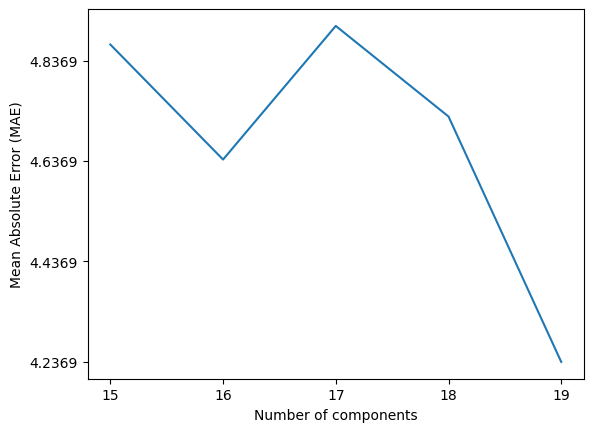

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


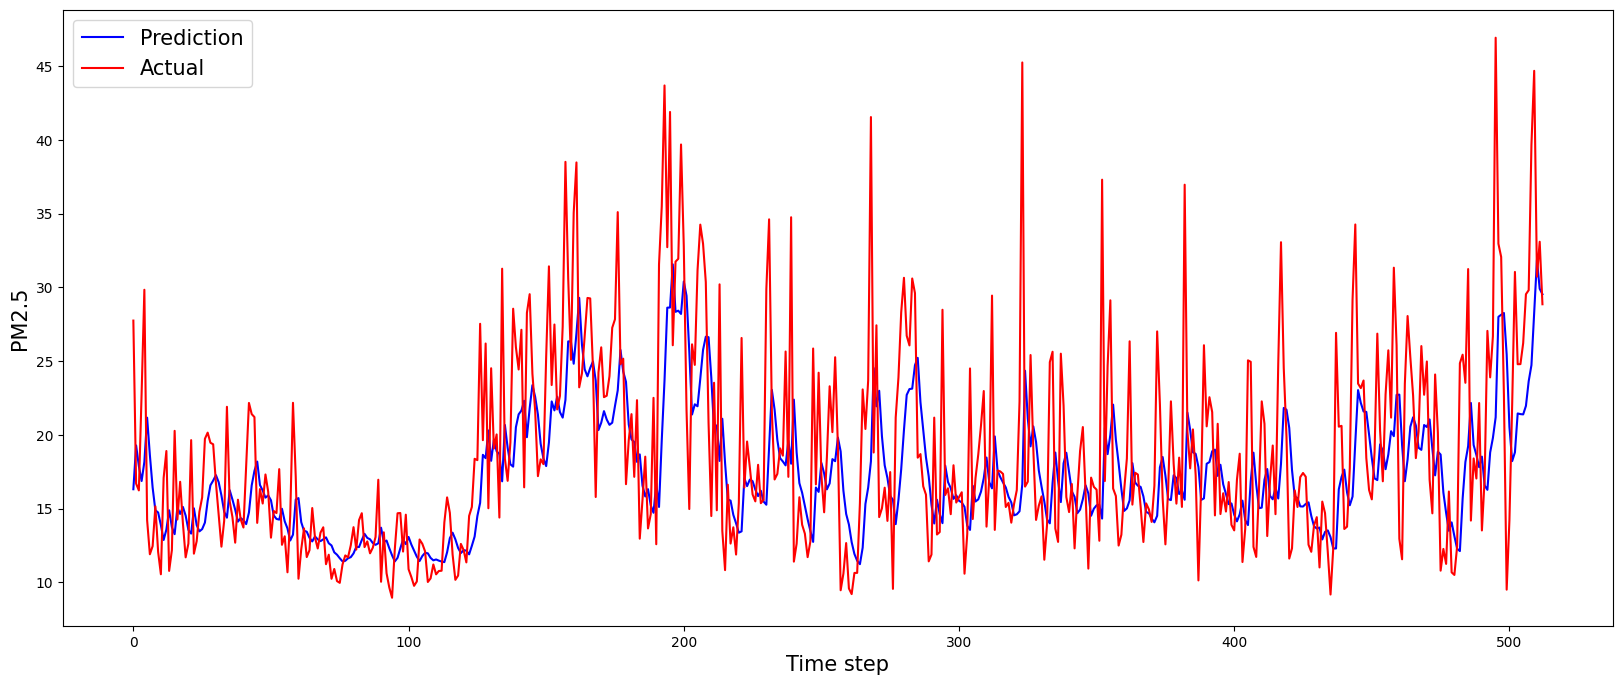

,with_pm25_3km,dim_reduction_method,dim_after_reduction,prediction,mae
0,Yes,LSTM-Seq2Seq,18,LSTM,4.556787
1,No,LSTM-Seq2Seq,17,LSTM,4.515589
2,yes,GRU-Seq2Seq,17,LSTM,4.204151
3,No,GRU-Seq2Seq,19,LSTM,4.236873


In [40]:
# Print out the number of features and corresponding MAE
for n in loopresults.keys():
    print(f"N = {n} - MAE = {loopresults[n]['mae']}")

# Visualize the relation between number of features and MAE
values = [loopresults[n]["mae"] for n in RANGE_OF_DIMENSION]
plt.plot(RANGE_OF_DIMENSION, values)
plt.xticks(RANGE_OF_DIMENSION)
plt.xlabel("Number of components")
plt.yticks(np.arange(min(values), max(values) + 0.1, 0.2))
plt.ylabel("Mean Absolute Error (MAE)")
plt.show()

# Choose the best number of features
best_mae, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = 1000, 0, None, None, None
for n in loopresults.keys():
    if loopresults[n]["mae"] < best_mae:
        best_num_of_components = n
        best_mae = loopresults[n]["mae"]
        best_encoded_data = loopresults[n]["encoded_data"]
        best_evaluation_data = loopresults[n]["evaluation_data"]
        best_encoder_model_path = loopresults[n]["encoder_model_path"]

# Visualize the prediction
all_days_inv_y_pred, all_days_inv_y_test, _, _ = best_evaluation_data
for day in range(conf["prediction"]["n_future"]):
    inv_y_pred = all_days_inv_y_pred[day,:,:]
    inv_y_test = all_days_inv_y_test[day,:,:]
    print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
    plot_2_data(data1=inv_y_pred,
                data2=inv_y_test,
                datalabel1="Prediction",
                datalabel2="Actual",
                xlabel="Time step",
                ylabel="PM2.5")

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["GRU-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]
evaluation_board['with_pm25_3km'] += ["No"]
pd.DataFrame(evaluation_board)

#### Prepare reduced data (no pm25_3km)

In [41]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_grus2s_reduced_no_pm25_3km = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_grus2s_reduced_no_pm25_3km.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_grus2s_reduced_2021_2022_no_pm25_3km.csv"))
df_grus2s_reduced_no_pm25_3km

,aod_feature_1,aod_feature_2,aod_feature_3,aod_feature_4,aod_feature_5,aod_feature_6,aod_feature_7,aod_feature_8,aod_feature_9,aod_feature_10,aod_feature_11,aod_feature_12,aod_feature_13,aod_feature_14,aod_feature_15,aod_feature_16,aod_feature_17,aod_feature_18,aod_feature_19,station
time,,,,,,,,,,,,,,,,,,,,
2021-01-01,0.114049,0.007766,0.008135,0.042301,0.014396,0.030129,0.037458,0.084200,0.045400,0.054151,0.025975,0.026733,0.029578,0.166147,0.008411,0.078729,0.158008,0.027395,0.041037,201
2021-01-02,0.114049,0.007766,0.008135,0.042301,0.014396,0.030129,0.037458,0.084200,0.045400,0.054151,0.025975,0.026733,0.029578,0.166147,0.008411,0.078729,0.158008,0.027395,0.041037,201
2021-01-03,0.113700,0.007845,0.008216,0.042231,0.014496,0.030312,0.037686,0.084699,0.045499,0.054548,0.026146,0.026862,0.029755,0.165053,0.008423,0.078393,0.157257,0.027549,0.041331,201
2021-01-04,0.113158,0.007918,0.008248,0.041974,0.014635,0.030530,0.037969,0.085433,0.045349,0.055213,0.026216,0.027091,0.029916,0.164072,0.008379,0.077860,0.156761,0.027638,0.041638,201
2021-01-05,0.112824,0.007903,0.008176,0.041651,0.014628,0.030516,0.038125,0.086310,0.045004,0.055782,0.026105,0.027203,0.029914,0.163710,0.008259,0.077431,0.157289,0.027516,0.041656,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,0.062831,0.023063,0.014108,0.044870,0.124928,0.040464,0.027973,0.032480,0.033654,0.064215,0.011428,0.042974,0.137556,0.049228,0.045358,0.026398,0.046638,0.066371,0.105463,216
2022-12-28,0.063311,0.023212,0.014250,0.044847,0.123774,0.040665,0.028187,0.032648,0.033847,0.064042,0.011624,0.043341,0.135618,0.049572,0.045408,0.026598,0.046999,0.066600,0.105455,216
2022-12-29,0.063146,0.023188,0.014253,0.045040,0.124180,0.040613,0.028233,0.032718,0.033874,0.064131,0.011600,0.043269,0.135831,0.049469,0.045363,0.026713,0.047100,0.066540,0.104737,216


### Prediction + CNN-LSTM Seq2seq

#### Doing the loop

In [42]:
loopresults = {i:{"mae": None, "encoded_data": None, "evaluation_data": None, "encoder_model_path": None} for i in RANGE_OF_DIMENSION}

# Loop between min and (number of features - 1) to choose what number is the best
for n in RANGE_OF_DIMENSION:
    # Apply Seq2seq
    cnnlstms2s = CNNLSTMSeq2SeqReduction(X_aod_scaled,
                                        test_percentage=0.2,
                                        latent_dim=n,
                                        n_past=conf["reduction"]["n_past"], n_future=conf["reduction"]["n_future"],
                                        epochs=conf["reduction"]["epochs"], batch_size=conf["reduction"]["batch_size"],
                                        verbose=0,
                                        model_name=f"aod_cnnlstms2s_dim_reduction_{n}_features")

    X_aod_scaled_cnnlstms2s_encoded, encoder_model_path = cnnlstms2s.execute()

    cnnlstms2s.get_model_info()
    cnnlstms2s.get_encoder_model_info()

    # Prediction
    y_pred, y_test = predictLSTM(X_aod_scaled_cnnlstms2s_encoded, y_aod_scaled,
                                n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                                epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                                model_name=f"aod_lstm_prediction_with_cnnlstms2s_dim_reduction_{n}_features",
                                verbose=0)

    # Evaluation
    all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, aod_label_scaler, verbose=0)

    # Logging
    loopresults[n]["mae"] = avg_mae
    loopresults[n]["encoded_data"] = X_aod_scaled_cnnlstms2s_encoded
    loopresults[n]["encoder_model_path"] = encoder_model_path
    loopresults[n]["evaluation_data"] = (all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae)

Could not load symbol cuFuncGetName. Error: /lib/x86_64-linux-gnu/libcuda.so.1: undefined symbol: cuFuncGetName


Model: "aod_cnnlstms2s_dim_reduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_60      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 5, 24)     │      1,464 │ input_layer_60[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 3, 12)     │        876 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 1, 12)     │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12)        │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_40    │ (None, 7, 12)     │          0 │ flatten[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_80 (LSTM)      │ [(None, 50),      │     12,600 │ repeat_vector_40… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_80 (Dense)    │ (None, 15)        │        765 │ lstm_80[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_41    │ (None, 7, 15)     │          0 │ dense_80[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_81 (LSTM)      │ (None, 7, 50)     │     13,200 │ repeat_vector_41… │
│                     │                   │            │ lstm_80[0][1],    │
│                     │                   │            │ lstm_80[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_60 │ (None, 7, 24)     │      1,224 │ lstm_81[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_61 │ (None, 7, 20)     │        500 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 91,889 (358.95 KB)

 Trainable params: 30,629 (119.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,260 (239.30 KB)

None


Model: "aod_cnnlstms2s_dim_reduction_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_61 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 5, 24)          │         1,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_40 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_80 (LSTM)                  │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,705 (61.35 KB)

 Trainable params: 15,705 (61.35 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_cnnlstms2s_dim_reduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_63      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 5, 24)     │      1,464 │ input_layer_63[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 3, 12)     │        876 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 1, 12)     │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_43    │ (None, 7, 12)     │          0 │ flatten_1[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_84 (LSTM)      │ [(None, 50),      │     12,600 │ repeat_vector_43… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_85 (Dense)    │ (None, 16)        │        816 │ lstm_84[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_44    │ (None, 7, 16)     │          0 │ dense_85[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_85 (LSTM)      │ (None, 7, 50)     │     13,400 │ repeat_vector_44… │
│                     │                   │            │ lstm_84[0][1],    │
│                     │                   │            │ lstm_84[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_64 │ (None, 7, 24)     │      1,224 │ lstm_85[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_65 │ (None, 7, 20)     │        500 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 92,642 (361.89 KB)

 Trainable params: 30,880 (120.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,762 (241.26 KB)

None


Model: "aod_cnnlstms2s_dim_reduction_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_64 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 5, 24)          │         1,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_43 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_84 (LSTM)                  │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,756 (61.55 KB)

 Trainable params: 15,756 (61.55 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_cnnlstms2s_dim_reduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_66      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 5, 24)     │      1,464 │ input_layer_66[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 3, 12)     │        876 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 1, 12)     │          0 │ conv1d_5[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_46    │ (None, 7, 12)     │          0 │ flatten_2[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_88 (LSTM)      │ [(None, 50),      │     12,600 │ repeat_vector_46… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_90 (Dense)    │ (None, 17)        │        867 │ lstm_88[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_47    │ (None, 7, 17)     │          0 │ dense_90[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_89 (LSTM)      │ (None, 7, 50)     │     13,600 │ repeat_vector_47… │
│                     │                   │            │ lstm_88[0][1],    │
│                     │                   │            │ lstm_88[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_68 │ (None, 7, 24)     │      1,224 │ lstm_89[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_69 │ (None, 7, 20)     │        500 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 93,395 (364.83 KB)

 Trainable params: 31,131 (121.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,264 (243.22 KB)

None


Model: "aod_cnnlstms2s_dim_reduction_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_67 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 5, 24)          │         1,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_46 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_88 (LSTM)                  │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,807 (61.75 KB)

 Trainable params: 15,807 (61.75 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_cnnlstms2s_dim_reduction_18_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_69      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 5, 24)     │      1,464 │ input_layer_69[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 3, 12)     │        876 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 1, 12)     │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_49    │ (None, 7, 12)     │          0 │ flatten_3[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_92 (LSTM)      │ [(None, 50),      │     12,600 │ repeat_vector_49… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_95 (Dense)    │ (None, 18)        │        918 │ lstm_92[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_50    │ (None, 7, 18)     │          0 │ dense_95[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_93 (LSTM)      │ (None, 7, 50)     │     13,800 │ repeat_vector_50… │
│                     │                   │            │ lstm_92[0][1],    │
│                     │                   │            │ lstm_92[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_72 │ (None, 7, 24)     │      1,224 │ lstm_93[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_73 │ (None, 7, 20)     │        500 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 94,148 (367.77 KB)

 Trainable params: 31,382 (122.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,766 (245.18 KB)

None


Model: "aod_cnnlstms2s_dim_reduction_18_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_70 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 5, 24)          │         1,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_49 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_92 (LSTM)                  │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 18)             │           918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,858 (61.95 KB)

 Trainable params: 15,858 (61.95 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_cnnlstms2s_dim_reduction_19_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_72      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 5, 24)     │      1,464 │ input_layer_72[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 3, 12)     │        876 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 1, 12)     │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_52    │ (None, 7, 12)     │          0 │ flatten_4[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_96 (LSTM)      │ [(None, 50),      │     12,600 │ repeat_vector_52… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_100 (Dense)   │ (None, 19)        │        969 │ lstm_96[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_53    │ (None, 7, 19)     │          0 │ dense_100[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_97 (LSTM)      │ (None, 7, 50)     │     14,000 │ repeat_vector_53… │
│                     │                   │            │ lstm_96[0][1],    │
│                     │                   │            │ lstm_96[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_76 │ (None, 7, 24)     │      1,224 │ lstm_97[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_77 │ (None, 7, 20)     │        500 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 94,901 (370.71 KB)

 Trainable params: 31,633 (123.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,268 (247.14 KB)

None


Model: "aod_cnnlstms2s_dim_reduction_19_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_73 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 5, 24)          │         1,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_52 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_96 (LSTM)                  │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 19)             │           969 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,909 (62.14 KB)

 Trainable params: 15,909 (62.14 KB)

 Non-trainable params: 0 (0.00 B)

None


N = 15 - MAE = 4.751211487549335
N = 16 - MAE = 4.863625363317404
N = 17 - MAE = 5.3768926931064245
N = 18 - MAE = 5.1864585888619645
N = 19 - MAE = 4.649495123653248


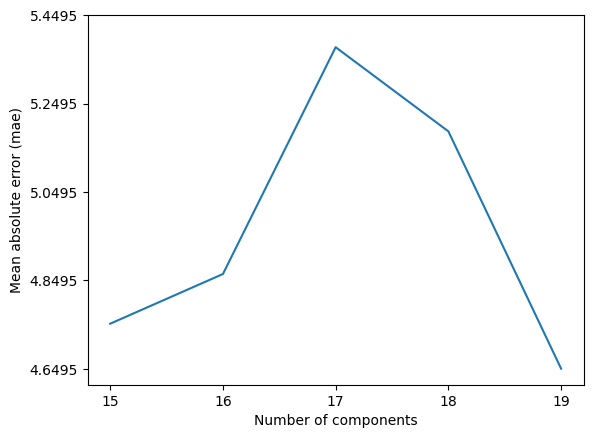

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


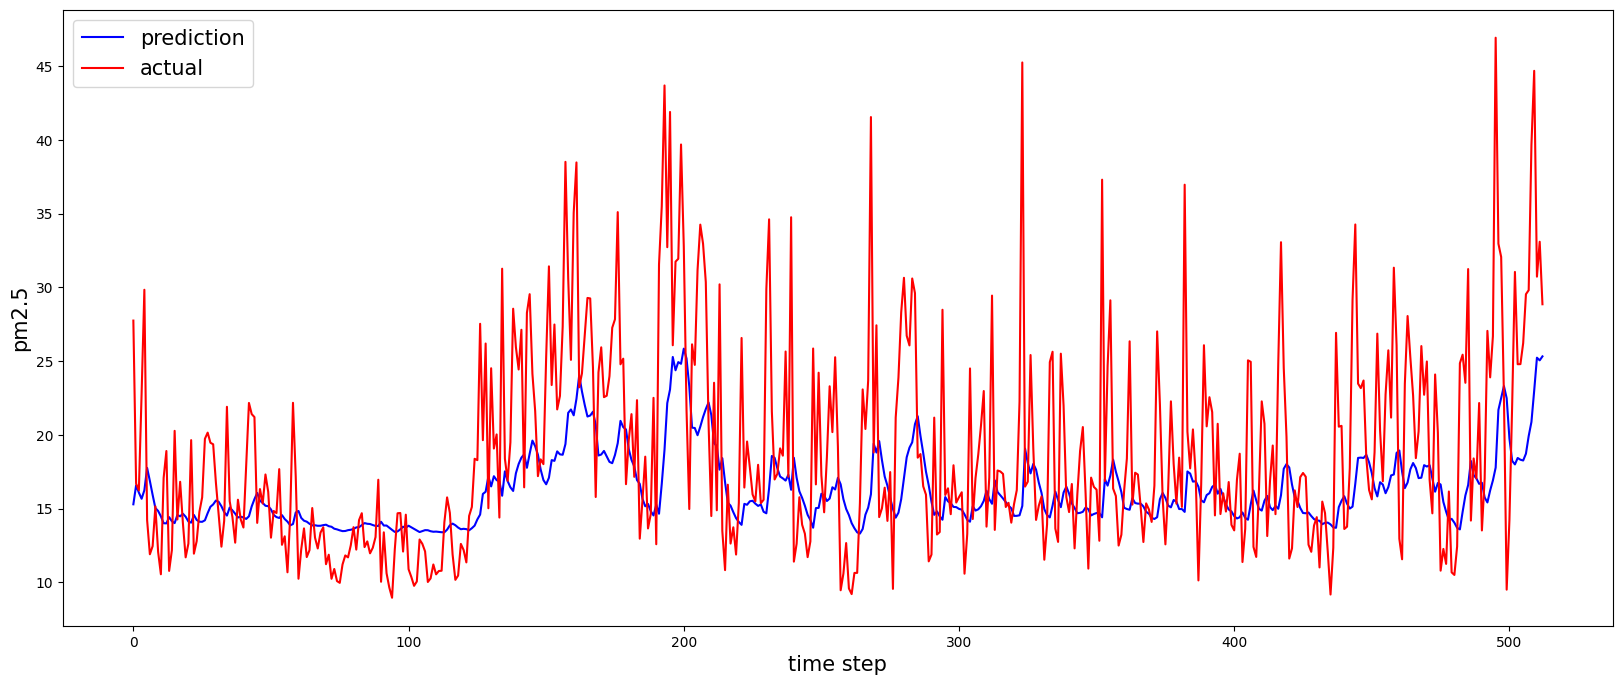

,with_pm25_3km,dim_reduction_method,dim_after_reduction,prediction,mae
0,Yes,LSTM-Seq2Seq,18,LSTM,4.556787
1,No,LSTM-Seq2Seq,17,LSTM,4.515589
2,yes,GRU-Seq2Seq,17,LSTM,4.204151
3,No,GRU-Seq2Seq,19,LSTM,4.236873
4,Yes,CNNLSTM-Seq2Seq,19,LSTM,4.649495


In [43]:
# Print out the number of features and corresponding mae
for n in loopresults.keys():
    print(f"N = {n} - MAE = {loopresults[n]['mae']}")

# visualize the relation between number of features and mae
values = [loopresults[n]["mae"] for n in RANGE_OF_DIMENSION]
plt.plot(RANGE_OF_DIMENSION, values)
plt.xticks(RANGE_OF_DIMENSION)
plt.xlabel("Number of components")
plt.yticks(np.arange(min(values), max(values) + 0.1, 0.2))
plt.ylabel("Mean absolute error (mae)")
plt.show()

# Choose the best number of features
best_mae, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = 1000, 0, None, None, None
for n in loopresults.keys():
    if loopresults[n]["mae"] < best_mae:
        best_num_of_components = n
        best_mae = loopresults[n]["mae"]
        best_encoded_data = loopresults[n]["encoded_data"]
        best_evaluation_data = loopresults[n]["evaluation_data"]
        best_encoder_model_path = loopresults[n]["encoder_model_path"]

# Visualize the prediction
all_days_inv_y_pred, all_days_inv_y_test, _, _ = best_evaluation_data
for day in range(conf["prediction"]["n_future"]):
    inv_y_pred = all_days_inv_y_pred[day,:,:]
    inv_y_test = all_days_inv_y_test[day,:,:]
    print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
    plot_2_data(data1=inv_y_pred,
                data2=inv_y_test,
                datalabel1="prediction",
                datalabel2="actual",
                xlabel="time step",
                ylabel="pm2.5")

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["CNNLSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]
evaluation_board['with_pm25_3km'] += ["Yes"]
pd.DataFrame(evaluation_board)

#### Prepare reduced data

In [44]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_cnnlstms2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_cnnlstms2s_reduced.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_cnnlstms2s_reduced_2021_2022.csv"))
df_cnnlstms2s_reduced

,aod_feature_1,aod_feature_2,aod_feature_3,aod_feature_4,aod_feature_5,aod_feature_6,aod_feature_7,aod_feature_8,aod_feature_9,aod_feature_10,aod_feature_11,aod_feature_12,aod_feature_13,aod_feature_14,aod_feature_15,aod_feature_16,aod_feature_17,aod_feature_18,aod_feature_19,station
time,,,,,,,,,,,,,,,,,,,,
2021-01-01,-0.145524,-0.099231,0.070796,-0.155613,-0.040735,0.465669,0.647285,-0.124096,0.111360,-0.416246,0.566236,-0.017933,0.372468,0.016236,0.112860,-0.126117,-0.076401,0.295135,0.282077,201
2021-01-02,-0.145524,-0.099231,0.070796,-0.155613,-0.040735,0.465669,0.647285,-0.124096,0.111360,-0.416246,0.566236,-0.017933,0.372468,0.016236,0.112860,-0.126117,-0.076401,0.295135,0.282077,201
2021-01-03,-0.145524,-0.099231,0.070796,-0.155613,-0.040735,0.465669,0.647285,-0.124096,0.111360,-0.416246,0.566236,-0.017933,0.372468,0.016236,0.112860,-0.126117,-0.076401,0.295135,0.282077,201
2021-01-04,-0.145661,-0.100212,0.071772,-0.157802,-0.041469,0.469778,0.651938,-0.126194,0.111011,-0.417825,0.569816,-0.016570,0.374562,0.017126,0.114227,-0.126745,-0.077986,0.297105,0.283780,201
2021-01-05,-0.145533,-0.100658,0.069068,-0.160465,-0.039446,0.466493,0.651322,-0.121670,0.108814,-0.417652,0.568828,-0.016846,0.374677,0.015978,0.109617,-0.126240,-0.075373,0.298151,0.280772,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,-0.319738,0.280854,-0.223903,-0.014543,0.291937,-0.104648,0.076535,0.480484,0.115753,-0.441548,0.071159,-0.038187,0.215207,-0.063907,-0.510832,0.014192,0.019395,0.031875,-0.141785,216
2022-12-28,-0.318494,0.279874,-0.229311,-0.015357,0.286588,-0.109911,0.074291,0.472546,0.114413,-0.433908,0.071858,-0.044241,0.213129,-0.059251,-0.506472,0.010268,0.022226,0.032805,-0.136636,216
2022-12-29,-0.308175,0.271164,-0.221197,-0.012037,0.280981,-0.099183,0.075057,0.459066,0.117028,-0.433531,0.069861,-0.037793,0.209870,-0.065283,-0.492923,0.005838,0.017620,0.034379,-0.133801,216


#### Doing the loop (no pm25_3km)

In [45]:
loopresults = {i:{"mae": None, "encoded_data": None, "evaluation_data": None, "encoder_model_path": None} for i in RANGE_OF_DIMENSION}

# Loop between min and (number of features - 1) to choose what number is the best
for n in RANGE_OF_DIMENSION:
    # Apply Seq2seq
    cnnlstms2s = CNNLSTMSeq2SeqReduction(X_aod_no_pm25_3km_scaled,
                                        test_percentage=0.2,
                                        latent_dim=n,
                                        n_past=conf["reduction"]["n_past"], n_future=conf["reduction"]["n_future"],
                                        epochs=conf["reduction"]["epochs"], batch_size=conf["reduction"]["batch_size"],
                                        verbose=0,
                                        model_name=f"aod_cnnlstms2s_dim_reduction_{n}_features_no_pm25_3km")

    X_aod_scaled_cnnlstms2s_encoded_no_pm25_3km, encoder_model_path = cnnlstms2s.execute()

    cnnlstms2s.get_model_info()
    cnnlstms2s.get_encoder_model_info()

    # Prediction
    y_pred, y_test = predictLSTM(X_aod_scaled_cnnlstms2s_encoded_no_pm25_3km, y_aod_scaled,
                                n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                                epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                                model_name=f"aod_lstm_prediction_with_cnnlstms2s_dim_reduction_{n}_features_no_pm25_3km",
                                verbose=0)

    # Evaluation
    all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, aod_label_scaler, verbose=0)

    # Logging
    loopresults[n]["mae"] = avg_mae
    loopresults[n]["encoded_data"] = X_aod_scaled_cnnlstms2s_encoded_no_pm25_3km
    loopresults[n]["encoder_model_path"] = encoder_model_path
    loopresults[n]["evaluation_data"] = (all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae)

Model: "aod_cnnlstms2s_dim_reduction_15_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_75      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 5, 24)     │      1,392 │ input_layer_75[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 1, 12)     │          0 │ conv1d_11[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_55    │ (None, 7, 12)     │          0 │ flatten_5[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_100 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_55… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_105 (Dense)   │ (None, 15)        │        765 │ lstm_100[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_56    │ (None, 7, 15)     │          0 │ dense_105[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_101 (LSTM)     │ (None, 7, 50)     │     13,200 │ repeat_vector_56… │
│                     │                   │            │ lstm_100[0][1],   │
│                     │                   │            │ lstm_100[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_80 │ (None, 7, 24)     │      1,224 │ lstm_101[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_81 │ (None, 7, 19)     │        475 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 91,598 (357.81 KB)

 Trainable params: 30,532 (119.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,066 (238.54 KB)

None


Model: "aod_cnnlstms2s_dim_reduction_15_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_76 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 5, 24)          │         1,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_55 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_100 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,633 (61.07 KB)

 Trainable params: 15,633 (61.07 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_cnnlstms2s_dim_reduction_16_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_78      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 5, 24)     │      1,392 │ input_layer_78[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 1, 12)     │          0 │ conv1d_13[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_58    │ (None, 7, 12)     │          0 │ flatten_6[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_104 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_58… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_110 (Dense)   │ (None, 16)        │        816 │ lstm_104[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_59    │ (None, 7, 16)     │          0 │ dense_110[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_105 (LSTM)     │ (None, 7, 50)     │     13,400 │ repeat_vector_59… │
│                     │                   │            │ lstm_104[0][1],   │
│                     │                   │            │ lstm_104[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_84 │ (None, 7, 24)     │      1,224 │ lstm_105[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_85 │ (None, 7, 19)     │        475 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 92,351 (360.75 KB)

 Trainable params: 30,783 (120.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,568 (240.50 KB)

None


Model: "aod_cnnlstms2s_dim_reduction_16_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_79 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 5, 24)          │         1,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_58 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_104 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,684 (61.27 KB)

 Trainable params: 15,684 (61.27 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_cnnlstms2s_dim_reduction_17_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_81      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 5, 24)     │      1,392 │ input_layer_81[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 1, 12)     │          0 │ conv1d_15[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_61    │ (None, 7, 12)     │          0 │ flatten_7[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_108 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_61… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_115 (Dense)   │ (None, 17)        │        867 │ lstm_108[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_62    │ (None, 7, 17)     │          0 │ dense_115[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_109 (LSTM)     │ (None, 7, 50)     │     13,600 │ repeat_vector_62… │
│                     │                   │            │ lstm_108[0][1],   │
│                     │                   │            │ lstm_108[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_88 │ (None, 7, 24)     │      1,224 │ lstm_109[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_89 │ (None, 7, 19)     │        475 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 93,104 (363.69 KB)

 Trainable params: 31,034 (121.23 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,070 (242.46 KB)

None


Model: "aod_cnnlstms2s_dim_reduction_17_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_82 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 5, 24)          │         1,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_61 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_108 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,735 (61.46 KB)

 Trainable params: 15,735 (61.46 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_cnnlstms2s_dim_reduction_18_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_84      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 5, 24)     │      1,392 │ input_layer_84[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 1, 12)     │          0 │ conv1d_17[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_64    │ (None, 7, 12)     │          0 │ flatten_8[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_112 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_64… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_120 (Dense)   │ (None, 18)        │        918 │ lstm_112[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_65    │ (None, 7, 18)     │          0 │ dense_120[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_113 (LSTM)     │ (None, 7, 50)     │     13,800 │ repeat_vector_65… │
│                     │                   │            │ lstm_112[0][1],   │
│                     │                   │            │ lstm_112[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_92 │ (None, 7, 24)     │      1,224 │ lstm_113[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_93 │ (None, 7, 19)     │        475 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 93,857 (366.63 KB)

 Trainable params: 31,285 (122.21 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,572 (244.43 KB)

None


Model: "aod_cnnlstms2s_dim_reduction_18_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_85 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 5, 24)          │         1,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_64 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_112 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 18)             │           918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,786 (61.66 KB)

 Trainable params: 15,786 (61.66 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_cnnlstms2s_dim_reduction_19_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_87      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 5, 24)     │      1,392 │ input_layer_87[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_18[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 1, 12)     │          0 │ conv1d_19[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_67    │ (None, 7, 12)     │          0 │ flatten_9[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_116 (LSTM)     │ [(None, 50),      │     12,600 │ repeat_vector_67… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_125 (Dense)   │ (None, 19)        │        969 │ lstm_116[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_68    │ (None, 7, 19)     │          0 │ dense_125[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_117 (LSTM)     │ (None, 7, 50)     │     14,000 │ repeat_vector_68… │
│                     │                   │            │ lstm_116[0][1],   │
│                     │                   │            │ lstm_116[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_96 │ (None, 7, 24)     │      1,224 │ lstm_117[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_97 │ (None, 7, 19)     │        475 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 94,610 (369.57 KB)

 Trainable params: 31,536 (123.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,074 (246.39 KB)

None


Model: "aod_cnnlstms2s_dim_reduction_19_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_88 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 5, 24)          │         1,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_67 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_116 (LSTM)                 │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 19)             │           969 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,837 (61.86 KB)

 Trainable params: 15,837 (61.86 KB)

 Non-trainable params: 0 (0.00 B)

None


N = 15 - MAE = 5.040558934804419
N = 16 - MAE = 5.936061147243736
N = 17 - MAE = 4.268006558482513
N = 18 - MAE = 4.505410515025823
N = 19 - MAE = 4.661737271285971


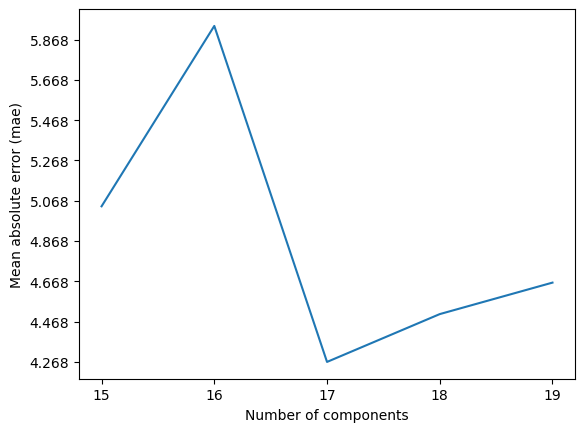

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


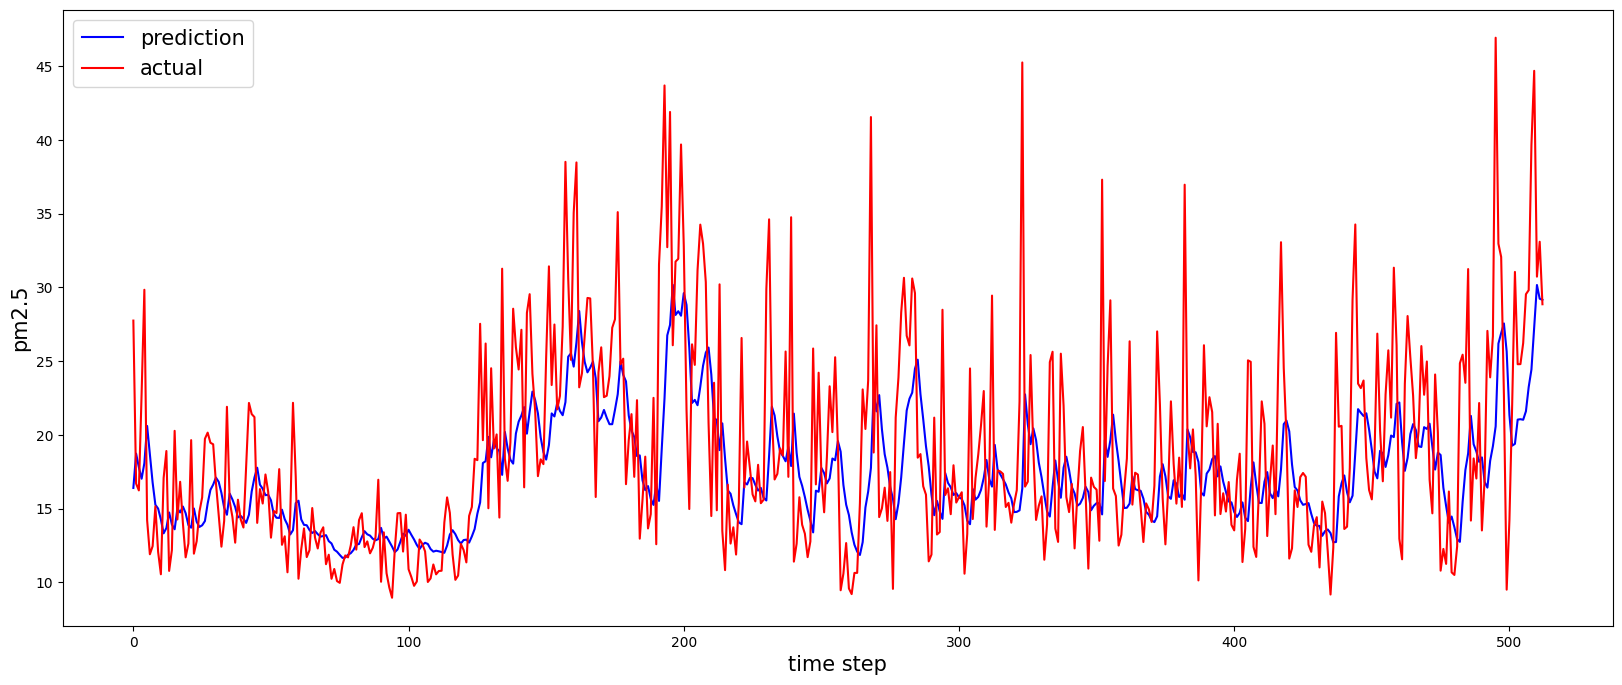

,with_pm25_3km,dim_reduction_method,dim_after_reduction,prediction,mae
0,Yes,LSTM-Seq2Seq,18,LSTM,4.556787
1,No,LSTM-Seq2Seq,17,LSTM,4.515589
2,yes,GRU-Seq2Seq,17,LSTM,4.204151
3,No,GRU-Seq2Seq,19,LSTM,4.236873
4,Yes,CNNLSTM-Seq2Seq,19,LSTM,4.649495
5,No,CNNLSTM-Seq2Seq,17,LSTM,4.268007


In [46]:
# Print out the number of features and corresponding mae
for n in loopresults.keys():
    print(f"N = {n} - MAE = {loopresults[n]['mae']}")

# Visualize the relation between number of features and mae
values = [loopresults[n]["mae"] for n in RANGE_OF_DIMENSION]
plt.plot(RANGE_OF_DIMENSION, values)
plt.xticks(RANGE_OF_DIMENSION)
plt.xlabel("Number of components")
plt.yticks(np.arange(min(values), max(values) + 0.1, 0.2))
plt.ylabel("Mean absolute error (mae)")
plt.show()

# Choose the best number of features
best_mae, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = 1000, 0, None, None, None
for n in loopresults.keys():
    if loopresults[n]["mae"] < best_mae:
        best_num_of_components = n
        best_mae = loopresults[n]["mae"]
        best_encoded_data = loopresults[n]["encoded_data"]
        best_evaluation_data = loopresults[n]["evaluation_data"]
        best_encoder_model_path = loopresults[n]["encoder_model_path"]

# Visualize the prediction
all_days_inv_y_pred, all_days_inv_y_test, _, _ = best_evaluation_data
for day in range(conf["prediction"]["n_future"]):
    inv_y_pred = all_days_inv_y_pred[day,:,:]
    inv_y_test = all_days_inv_y_test[day,:,:]
    print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
    plot_2_data(data1=inv_y_pred,
                data2=inv_y_test,
                datalabel1="prediction",
                datalabel2="actual",
                xlabel="time step",
                ylabel="pm2.5")

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["CNNLSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]
evaluation_board['with_pm25_3km'] += ["No"]
pd.DataFrame(evaluation_board)

#### Prepare reduced data

In [47]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_cnnlstms2s_reduced_no_pm25_3km = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_cnnlstms2s_reduced_no_pm25_3km.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_cnnlstms2s_reduced_2021_2022_no_pm25_3km.csv"))
df_cnnlstms2s_reduced_no_pm25_3km

,aod_feature_1,aod_feature_2,aod_feature_3,aod_feature_4,aod_feature_5,aod_feature_6,aod_feature_7,aod_feature_8,aod_feature_9,aod_feature_10,aod_feature_11,aod_feature_12,aod_feature_13,aod_feature_14,aod_feature_15,aod_feature_16,aod_feature_17,station
time,,,,,,,,,,,,,,,,,,
2021-01-01,0.168822,0.241835,0.383799,-0.222332,-0.145992,-0.022805,0.121117,0.324573,-0.007236,-0.051435,0.406251,-0.021582,0.222137,-0.382259,0.234067,0.030678,-0.234499,201
2021-01-02,0.168822,0.241835,0.383799,-0.222332,-0.145992,-0.022805,0.121117,0.324573,-0.007236,-0.051435,0.406251,-0.021582,0.222137,-0.382259,0.234067,0.030678,-0.234499,201
2021-01-03,0.168822,0.241835,0.383799,-0.222332,-0.145992,-0.022805,0.121117,0.324573,-0.007236,-0.051435,0.406251,-0.021582,0.222137,-0.382259,0.234067,0.030678,-0.234499,201
2021-01-04,0.170424,0.242989,0.384362,-0.222645,-0.147996,-0.024001,0.119444,0.324529,-0.005693,-0.050300,0.406173,-0.021093,0.221678,-0.382896,0.234772,0.030731,-0.233630,201
2021-01-05,0.172229,0.242453,0.384210,-0.222029,-0.149164,-0.023810,0.118651,0.325140,-0.005426,-0.050779,0.405632,-0.020448,0.221596,-0.383028,0.234019,0.031226,-0.232580,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,0.083860,0.296456,0.388451,-0.195909,-0.108025,0.011338,0.149063,0.365994,-0.064095,-0.016908,0.430124,0.037864,0.239741,-0.299757,0.233984,0.014646,-0.307279,216
2022-12-28,0.082172,0.289176,0.388790,-0.191819,-0.094681,0.007508,0.149160,0.361128,-0.068685,-0.014069,0.421752,0.041284,0.240502,-0.298110,0.231878,0.011974,-0.310534,216
2022-12-29,0.073236,0.284681,0.384284,-0.196726,-0.086968,0.005582,0.145890,0.344341,-0.070315,-0.011604,0.407532,0.037725,0.240388,-0.293816,0.229103,0.001188,-0.309653,216


## Compare the score

In [48]:
y_aod_scaled

,pm25
0,0.147032
1,0.216931
2,0.281258
3,0.287336
4,0.239218
...,...
2568,0.419453
2569,0.480472
2570,0.310835
2571,0.339606


### LSTM-Seq2Seq

In [49]:
print(df_lstms2s_reduced.shape)
df_lstms2s_reduced

(2573, 19)


,aod_feature_1,aod_feature_2,aod_feature_3,aod_feature_4,aod_feature_5,aod_feature_6,aod_feature_7,aod_feature_8,aod_feature_9,aod_feature_10,aod_feature_11,aod_feature_12,aod_feature_13,aod_feature_14,aod_feature_15,aod_feature_16,aod_feature_17,aod_feature_18,station
time,,,,,,,,,,,,,,,,,,,
2021-01-01,-0.063893,-0.888072,-0.016788,0.028726,0.129592,0.181458,0.037677,0.501425,-0.478962,0.079657,-0.609621,0.211925,0.335851,-0.048941,-0.225357,0.335628,-0.265181,-0.078221,201
2021-01-02,-0.063893,-0.888072,-0.016788,0.028726,0.129592,0.181458,0.037677,0.501425,-0.478962,0.079657,-0.609621,0.211925,0.335851,-0.048941,-0.225357,0.335628,-0.265181,-0.078221,201
2021-01-03,-0.063488,-0.886277,-0.017226,0.028266,0.131020,0.181259,0.037101,0.500945,-0.477822,0.078643,-0.609770,0.212933,0.334923,-0.049232,-0.225052,0.336249,-0.264721,-0.078539,201
2021-01-04,-0.062140,-0.883686,-0.018362,0.027120,0.133265,0.180572,0.036898,0.500612,-0.476665,0.078678,-0.610720,0.214079,0.333268,-0.049538,-0.224187,0.337279,-0.264478,-0.079026,201
2021-01-05,-0.060250,-0.881575,-0.020324,0.026451,0.136342,0.178584,0.037753,0.501586,-0.476599,0.080073,-0.612880,0.215094,0.331835,-0.050859,-0.223265,0.337810,-0.263783,-0.080038,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,0.060881,-0.550532,-0.385914,0.163463,0.149512,-0.109391,-0.074167,0.304030,-0.239969,0.191119,-0.772819,0.092904,0.315826,-0.391945,-0.539535,-0.384634,-0.241266,0.242112,216
2022-12-28,0.059431,-0.548406,-0.382029,0.162440,0.148015,-0.108940,-0.074402,0.301949,-0.239481,0.190249,-0.767813,0.092920,0.313821,-0.388712,-0.536549,-0.381309,-0.239229,0.240330,216
2022-12-29,0.056392,-0.544696,-0.376780,0.160428,0.146966,-0.109282,-0.076280,0.300236,-0.238724,0.189526,-0.759600,0.092349,0.310424,-0.386729,-0.531226,-0.379234,-0.237111,0.239789,216


In [50]:
y_pred = predictLSTMNoSplit(df_lstms2s_reduced.drop(columns=["station"], axis=1), y_aod_scaled,
                           n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                           epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                           model_name=f"aod_lstm_prediction_no_split_with_lstms2s_dim_reduction_{df_lstms2s_reduced.shape[-1]}_features",
                           verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


In [51]:
print(y_pred.shape)
y_pred

(2573, 1, 1)


array([[[0.14741968]],

       [[0.14741968]],

       [[0.15693326]],

       ...,

       [[0.29477912]],

       [[0.28976208]],

       [[0.2910433 ]]], dtype=float32)

In [52]:
y_pred_reshaped = y_pred.reshape([-1, 1])
df_y_pred = pd.DataFrame(y_pred_reshaped)
df_y_pred

,0
0,0.147420
1,0.147420
2,0.156933
3,0.173948
4,0.187923
...,...
2568,0.242826
2569,0.268229
2570,0.294779
2571,0.289762


In [53]:
inv_y_aod = aod_label_scaler.inverse_transform(y_aod_scaled)
inv_y_aod

array([[17.25      ],
       [23.        ],
       [28.29166667],
       ...,
       [30.7247081 ],
       [33.09142799],
       [28.85406871]])

In [54]:
inv_y_pred = aod_label_scaler.inverse_transform(df_y_pred)
inv_y_pred

array([[17.28187 ],
       [17.28187 ],
       [18.064474],
       ...,
       [29.403925],
       [28.991213],
       [29.09661 ]], dtype=float32)

5.58808648176108
7.768970258629239


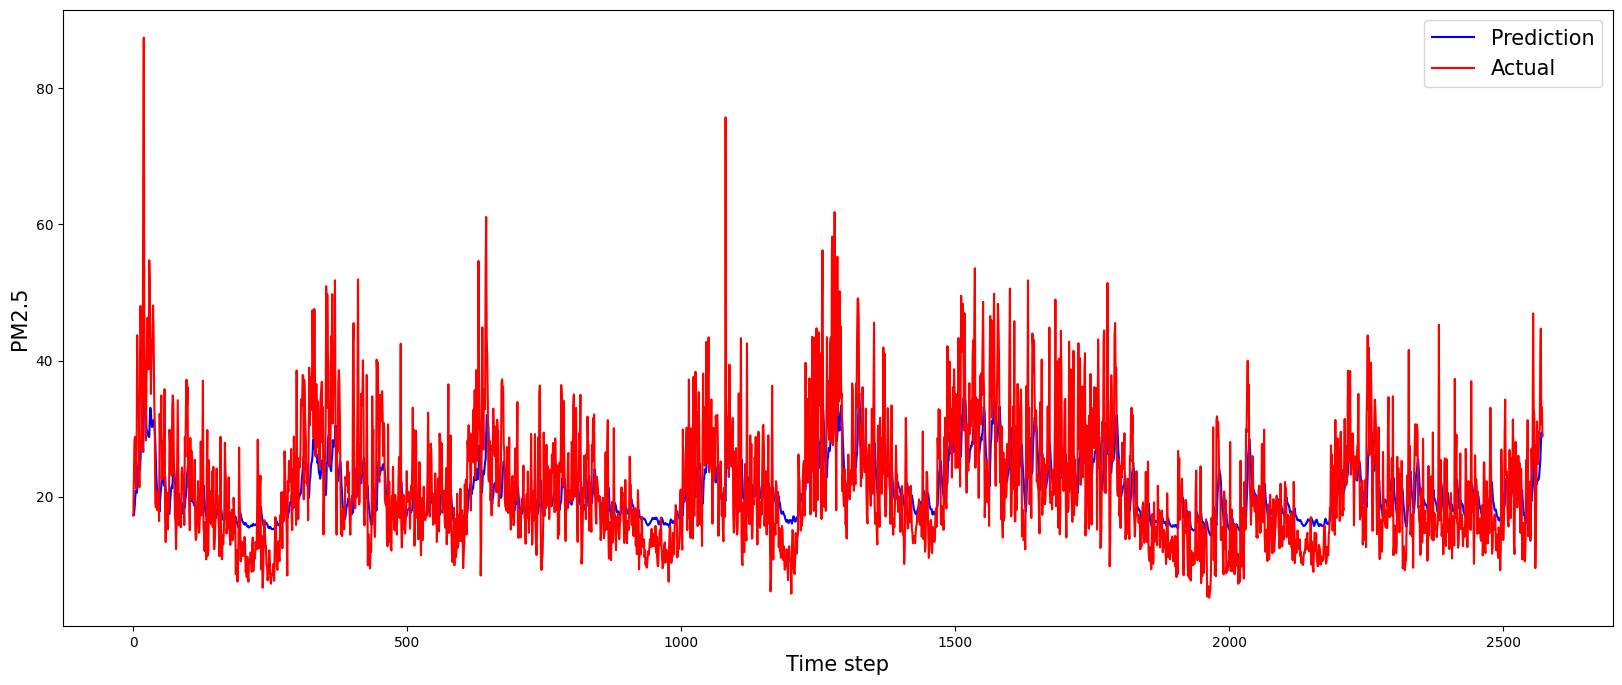

In [55]:
# Print out the MAE
print(mean_absolute_error(inv_y_aod, inv_y_pred))
print(mean_absolute_error(df_aod_raw["pm25"], df_aod_raw["pm25_3km"]))

# Visualization
plot_2_data(data1=inv_y_pred,
            data2=inv_y_aod,
            datalabel1="Prediction",
            datalabel2="Actual",
            xlabel="Time step",
            ylabel="PM2.5")

In [56]:
stophere

NameError: name 'stophere' is not defined

### GRU-Seq2Seq

In [ ]:
print(df_grus2s_reduced.shape)
df_grus2s_reduced

In [ ]:
y_pred = predictLSTMNoSplit(df_grus2s_reduced.drop(columns=["station"], axis=1), y_aod_scaled,
                           n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                           epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                           model_name=f"aod_gru_s2s_lstm_predict_no_split",
                           verbose=0)

In [ ]:
print(y_pred.shape)
y_pred

In [ ]:
y_pred_reshaped = y_pred.reshape([-1, 1])
df_y_pred = pd.DataFrame(y_pred_reshaped)
df_y_pred

In [ ]:
inv_y_aod = aod_label_scaler.inverse_transform(y_aod_scaled)
inv_y_aod

In [ ]:
inv_y_pred = aod_label_scaler.inverse_transform(df_y_pred)
inv_y_pred

In [ ]:
mean_absolute_error(inv_y_aod, inv_y_pred)

In [ ]:
mean_absolute_error(df_aod_raw["pm25"], df_aod_raw["pm25_3km"])

In [ ]:
plot_2_data(data1=inv_y_pred,
            data2=inv_y_aod,
            datalabel1="Prediction",
            datalabel2="Actual",
            xlabel="Time step",
            ylabel="PM2.5")

### CNNLSTM-Seq2Seq

In [ ]:
print(df_cnnlstms2s_reduced.shape)
df_cnnlstms2s_reduced

In [ ]:
y_pred = predictLSTMNoSplit(df_cnnlstms2s_reduced.drop(columns=["station"], axis=1), y_aod_scaled,
                           n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                           epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                           model_name=f"aod_cnnlstm_s2s_lstm_predict_no_split",
                           verbose=0)

In [ ]:
print(y_pred.shape)
y_pred

In [ ]:
y_pred_reshaped = y_pred.reshape([-1, 1])
df_y_pred = pd.DataFrame(y_pred_reshaped)
df_y_pred

In [ ]:
inv_y_aod = aod_label_scaler.inverse_transform(y_aod_scaled)
inv_y_aod

In [ ]:
inv_y_pred = aod_label_scaler.inverse_transform(df_y_pred)
inv_y_pred

In [ ]:
mean_absolute_error(inv_y_aod, inv_y_pred)

In [ ]:
mean_absolute_error(df_aod_raw["pm25"], df_aod_raw["pm25_3km"])

In [ ]:
plot_2_data(data1=inv_y_pred,
            data2=inv_y_aod,
            datalabel1="Prediction",
            datalabel2="Actual",
            xlabel="Time step",
            ylabel="PM2.5")